# Longitudinal Exploratory Data Analysis

**Carlos Stefano Filho** <br>
*Data Scientist, PhD*

___
This notebook contains a longitudinal exploratory data analysis (LEDA).

The general idea is to infer relations between socioeconomical and educational budget indicators with students' performance in ENEM. We do that, however, with a time-varying approach, attempting to identify trends and overall patterns that might occur throughout several years of ENEM data.

Years analyzed in this study range from 2015 - 2022.

The general pipeline of analysis in this notebook can be extended to other years as well.

___

In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import linregress, spearmanr, pointbiserialr
from sklearn.decomposition import PCA
from preprocess import load_and_preprocess_ENEM_raw_data
from external_data_loading import get_metrics_from_inep_education_summary, get_residencial_earnings_per_capita_gini_index, get_public_safety_metrics, get_siope_data, SIOPE_METRICS_DICT

## 1. Data loading

##### General definitions

In [2]:
years_to_analyze = np.arange(2015, 2023)
# common_path = "../Datasets/enem-inep-data/"
common_path = "D:/students_performance_project/Datasets/enem-inep-data"

### 1.1. Evaluating raw data

In [6]:
registrations_and_absences = {'year': [], 'absences': [], 'registrations': []} # to store students' absences and registrations in ENEM for each year
UF_nan_values = {'year': [], 'UF_nan': []} # to store UF's NaN values for each year, separately

for year in [2015]:
    print(f"Running for {year} ")
    df = pd.read_csv(f"D:/students_performance_project/Datasets/enem-inep-data/{year}/DADOS/MICRODADOS_ENEM_{year}.csv", sep = ';', encoding = 'latin1')
    
    print("Preprocessing data...")
    registrations_and_absences['year'].append(year)
    registrations_and_absences['registrations'].append(df.shape[0])
    registrations_and_absences['absences'].append(df[(df['TP_PRESENCA_CN'].isin([0,2])) | (df['TP_PRESENCA_CH'].isin([0,2]))
    | (df['TP_PRESENCA_MT'].isin([0,2])) | (df['TP_PRESENCA_LC'].isin([0,2])) 
    | (df['TP_STATUS_REDACAO'] != 1)].shape[0])

    UF_nan_values['year'].append(year)
    UF_nan_values['UF_nan'].append(df.isna().sum()["UF_SG_ESC"])

    del df

Running for 2015 
Preprocessing data...


KeyError: 'UF_SG_ESC'

In [8]:
df.shape

(7746427, 105)

Students' registrations and absences

<AxesSubplot: title={'center': 'Total de alunos'}, xlabel='Ano'>

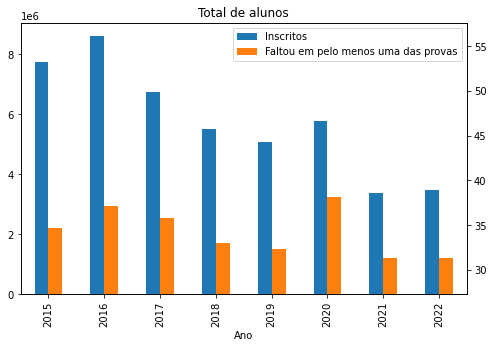

In [49]:
# Students' registrations and absences plot
df = pd.DataFrame(registrations_and_absences)

fig, ax1 = plt.subplots(1,1, figsize = (8,5))
ax2 = ax1.twinx()

df["Percentual de alunos faltantes"] = 100*df["absences"]/df["registrations"]
df.rename(columns = {"year": 'Ano', "absences": "Faltou em pelo menos uma das provas", "registrations": "Inscritos"}, inplace = True)

df.groupby("Ano")["Percentual de alunos faltantes"].mean().plot(ax = ax2)
ax2.plot(df["Ano"], df["Percentual de alunos faltantes"], 'r-.')
df.groupby("Ano")[["Inscritos", "Faltou em pelo menos uma das provas"]].mean().plot(kind = 'bar',
    figsize = (8,5),
    title = "Total de alunos",
    ax = ax1)
# ax1.set_xticklabels(labels = df["Ano"], rotation = 45)





From the graphic plotted above, we can understand students' registrations to take ENEM in each year, as well as their absences, in absolute numbers. It is worth noting the increase in absences for 2020, the year the COVID-19 pandemic ecloded.

Overall, absence ratios remained between 28 - 39 % for most years (except for 2020).

Students who missed at least one of ENEM's exams were not considered in the analysis.

In [28]:
# storing dataframe
joblib.dump(df, "inscrições_e_faltas.pkl")

['inscrições_e_faltas.pkl']

___
##### Top10 variables with the most null values

Let us plot average and standard deviation for the columns with the most null values between 2015 and 2023. This should aid us in defining which columns should be excluded due to  excess of missing data.

In [82]:
null_values_df = pd.DataFrame()
for year in years_to_analyze:
    df_year = pd.read_csv(f"../Datasets/enem-inep-data/{year}/DADOS/MICRODADOS_ENEM_{year}.csv", sep = ';', encoding = 'latin1')
    df_year = df_year.isna().sum()/df_year.shape[0]
    df_year.rename(year, inplace = True)
    null_values_df = pd.concat([null_values_df, df_year], axis = 1)
    del df_year
joblib.dump(null_values_df, "null_values_sum_2015_to_2023.pkl")

['null_values_sum_2015_to_2023.pkl']

In [86]:
# Visualizing in raw, "table", format
null_values_df.sort_values(by = 2022, ascending = False)

2015          2016      2017      2018      2019  \
TP_LOCALIZACAO_ESC      0.787094  7.819423e-01  0.734689  0.737235  0.774809   
CO_UF_ESC               0.787094  7.819423e-01  0.734689  0.737235  0.774809   
TP_SIT_FUNC_ESC         0.787322  7.819468e-01  0.735574  0.737235  0.774809   
TP_DEPENDENCIA_ADM_ESC  0.787094  7.819423e-01  0.734689  0.737235  0.774809   
SG_UF_ESC               0.787094  7.819423e-01  0.734689  0.737235  0.774809   
...                          ...           ...       ...       ...       ...   
Q046                    0.000103  4.636510e-07       NaN       NaN       NaN   
Q047                    0.000103  4.636510e-07       NaN       NaN       NaN   
Q048                    0.000103  4.636510e-07       NaN       NaN       NaN   
Q049                    0.000103  4.636510e-07       NaN       NaN       NaN   
Q050                    0.000103  4.636510e-07       NaN       NaN       NaN   

                            2020      2021      2022  
TP_LOCALIZACAO_ESC      0.843584  0.759927  0.726146  
CO_UF_ESC               0.843584  0.759927  0.726146  
TP_SIT_FUNC_ESC         0.843584  0.759927  0.726146  
TP_DEPENDENCIA_ADM_ESC  0.843584  0.759927  0.726146  
SG_UF_ESC               0.843584  0.759927  0.726146  
...                          ...       ...       ...  
Q046                         NaN       NaN       NaN  
Q047                         NaN       NaN       NaN  
Q048                         NaN       NaN       NaN  
Q049                         NaN       NaN       NaN  
Q050                         NaN       NaN       NaN  

[105 rows x 8 columns]

In [94]:
nv = pd.concat([null_values_df.mean(axis = 1), null_values_df.std(axis=1)], axis = 1).rename(columns = {0: "Média", 1: "Desvio-padrão"})
nv.to_excel("../mean_and_std_null_values.xlsx") # Excel export

<ipython-input-94-2c8dcbbd1ea4>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  nv.to_excel("../mean_and_std_null_values.xlsx")


In [63]:
nan_values_2 = df[(df['TP_PRESENCA_CN'].isin([0,2])) | (df['TP_PRESENCA_CH'].isin([0,2]))
    | (df['TP_PRESENCA_MT'].isin([0,2])) | (df['TP_PRESENCA_LC'].isin([0,2])) 
    | (df['TP_STATUS_REDACAO'] != 1)].isna().sum()

In [64]:
nan_values_2[["SG_UF_ESC", "SG_UF_PROVA", "CO_UF_ESC", "CO_UF_PROVA"]]

SG_UF_ESC      937764
SG_UF_PROVA         0
CO_UF_ESC      937764
CO_UF_PROVA         0
dtype: int64

In [3]:
nan_values = joblib.load("null_values_sum_2015_to_2023.pkl")

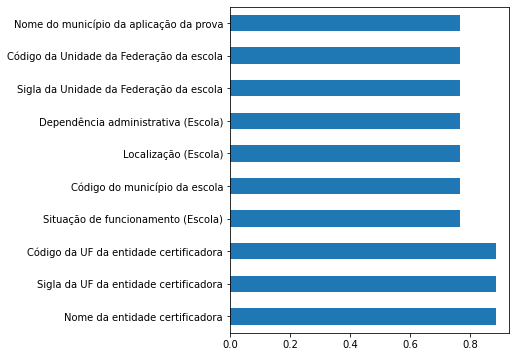

In [25]:
rects = nan_values.mean(axis = 1)\
    .sort_values(ascending = False)[0:10]\
    .rename(index = {'NO_MUNICIPIO_ESC': 'Nome do município da aplicação da prova',
        'CO_MUNICIPIO_ESC': 'Código do município da escola',
        'SG_UF_ESC': 'Sigla da Unidade da Federação da escola',
        'TP_DEPENDENCIA_ADM_ESC': 'Dependência administrativa (Escola)',
        'TP_SIT_FUNC_ESC': 'Situação de funcionamento (Escola)',
        'CO_UF_ESC': 'Código da Unidade da Federação da escola',
        'TP_LOCALIZACAO_ESC': 'Localização (Escola)',
        'CO_UF_ENTIDADE_CERTIFICACAO': 'Código da UF da entidade certificadora',
        'SG_UF_ENTIDADE_CERTIFICACAO': 'Sigla da UF da entidade certificadora',
        'NO_ENTIDADE_CERTIFICACAO': 'Nome da entidade certificadora'})\
    .plot(kind = 'barh', figsize = (5, 6))


We can see thatthere are columns with the majority (> 80%) of data missing, rendering them virtually unusable for our case, since we do not have an elaborate approach for filling in these missing values.
___

### 1.2. ENEM processed data

In [4]:
# Reading ENEM raw data, as downloaded from INEP's website, and executing a few processing steps on the data
enem_df = pd.DataFrame()
for year in [2015]:
    print(f"Processing data for {year}")
    df = load_and_preprocess_ENEM_raw_data(filepath = common_path + f"{year}/DADOS/MICRODADOS_ENEM_{year}.csv", enem_year = year)
    df['ENEM_year'] = year

    df['School type'] = df['TP_ESCOLA'].apply(lambda x: 
                                                'Public' if x == 2 
                                                else 'Private' if x == 3
                                                else 'No answer')

    joblib.dump(df, f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    print(f"Saved data for {year}!\n")

    enem_df = pd.concat([enem_df, df], axis = 0)
    del df
joblib.dump(enem_df, f"ENEM_dataframe_years_{years_to_analyze[0]}_to_{years_to_analyze[-1]}_based_on_SG_UF_PROVA")

Processing data for 2015
Saved data for 2015!

Processing data for 2016
Saved data for 2016!

Processing data for 2017
Saved data for 2017!

Processing data for 2018
Saved data for 2018!

Processing data for 2019
Saved data for 2019!

Processing data for 2020
Saved data for 2020!

Processing data for 2021
Saved data for 2021!

Processing data for 2022
Saved data for 2022!



['ENEM_dataframe_years_2015_to_2022_based_on_SG_UF_PROVA']

### 1.3. External data

We will read the external data using the functions in "external_data_loading.py".

In [112]:
siope_df = get_siope_data("../Datasets/external-data/siope-data")

In [39]:
siope_df

year metric_code  metric_value  UF  \
0     2008         2.1          0.00  RO   
1     2008        4.11         62.50  RO   
2     2008         2.3          0.00  RO   
3     2008         2.4          0.00  RO   
4     2008         2.5         78.36  RO   
...    ...         ...           ...  ..   
7393  2017        2.12          0.16  DF   
7394  2017         3.5         73.01  DF   
7395  2017         4.1       7464.85  DF   
7396  2017         4.2       9904.41  DF   
7397  2017         4.9       8465.67  DF   

                              metric_description  
0                                EI_FUNDEB_ratio  
1     EB_non_teaching_staff_per_student_expanses  
2                                EM_FUNDEB_ratio  
3                 EI_to_total_education_expanses  
4                 EF_to_total_education_expanses  
...                                          ...  
7393          education_to_total_MDE_investments  
7394                 FUNDEB_teacher_to_total_MDE  
7395                   EI_investment_per_student  
7396                   EF_investment_per_student  
7397                      investment_per_student  

[7398 rows x 5 columns]

## 2. Correlation analysis

In [233]:
# load data, if needed
enem_df = joblib.load("C:/Users/cstefano/students_performance_project/data analysis/ENEM_dataframe_years_2015_to_2022_based_on_SG_UF_PROVA.pkl")
enem_df.drop(columns = "TP_ESCOLA", inplace = True)

In [4]:
# Dataframe with processed data of ENEM from all years
enem_df.shape

(29749997, 40)

In [5]:
enem_df_with_dummies = pd.get_dummies(enem_df, columns = ['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
                                   'Q001', 'Q002', 'Q003', 'Q004',
                                   'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
                                   'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
                                   'Q023', 'Q024', 'Q025', 'School type'])

### 2.1. Correlation of variables throughout the years - ENEM database

In [12]:
def pointbiserial_corr(x,y):
    return pointbiserialr(x,y)[0]

In [14]:
enem_df.columns

Index(['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
       'High school conclusion year', 'School type', 'UF', 'SG_UF_PROVA',
       'Natural Sciences score', 'Humanities score', 'Languages score',
       'Math score', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007',
       'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025',
       'Average score', 'ENEM_year'],
      dtype='object')

In [15]:
enem_2022 = enem_df_with_dummies[enem_df_with_dummies["ENEM_year"] == 2022].drop(columns = ["Natural Sciences score", "Humanities score",
                                                                                            "Languages score", "Math score"])

In [16]:
R = enem_2022.corr(method = pointbiserial_corr)

<ipython-input-16-c8225e3a59a4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  R = enem_2022.corr(method = pointbiserial_corr)
c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [21]:
joblib.dump(R, "./variables_results/ENEM_2022_correlations_with_UF_SG_PROVA_point_biserial.pkl")

['./variables_results/ENEM_2022_correlations_with_UF_SG_PROVA_point_biserial.pkl']

In [17]:
R["Average score"].sort_values(ascending = False)[0:15]

Average score    1.000000
Q018_B           0.309980
Q016_B           0.269638
Ethinicity_1     0.262456
Q014_B           0.257375
Q003_E           0.247566
Q004_D           0.226896
Q003_D           0.226652
Q001_G           0.223729
Q024_C           0.223499
Q002_G           0.222108
Q010_C           0.210201
Q013_B           0.209828
Q001_F           0.208959
Q004_E           0.207475
Name: Average score, dtype: float64

In [18]:
R["Average score"].sort_values(ascending = False)[0:15]

Average score             1.000000
Humanities score          0.872722
Math score                0.864417
Languages score           0.848827
Natural Sciences score    0.773551
School type_Private       0.393106
Q018_B                    0.318025
Ethinicity_1              0.280829
Q016_B                    0.269654
Q003_E                    0.259102
Q014_B                    0.258889
Q001_G                    0.237446
Q002_G                    0.234679
Q003_D                    0.223616
Q004_D                    0.223457
Name: Average score, dtype: float64

In [30]:
x = joblib.load("./variables_results/ENEM_2022_correlations_with_UF_SG_PROVA_point_biserial.pkl")
joblib.dump(x["Average score"], "./variables_results/ENEM_2022_average_score_correlations_with_UF_SG_PROVA_point_biserial.pkl")
del x

In [25]:
# Correlations within ENEM databases for each year under analysis
years_to_analyze = np.arange(2015, 2022)
for year in years_to_analyze:
    print(f"Calculating correlations for {year} data")
    correlations_enem_data = enem_df_with_dummies[enem_df_with_dummies["ENEM_year"] == year]\
        .drop(columns = "ENEM_year")\
        .corr(method = pointbiserial_corr, numeric_only = True)
    
    joblib.dump(correlations_enem_data, f"./variables_results/ENEM_{year}_correlations_with_UF_SG_PROVA_point_biserial.pkl")
    joblib.dump(correlations_enem_data["Average score"], f"./variables_results/ENEM_{year}_average_score_correlations_with_UF_SG_PROVA_point_biserial.pkl")

    del correlations_enem_data

Calculating correlations for 2015 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2016 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2017 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2018 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2019 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2020 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2021 data


Evaluating correlations year-wise

##### Loading data

In [98]:
# Considering the student belongs to the same UF where they took the test
years_to_analyze = np.arange(2015, 2023)
R = pd.DataFrame()
for year in years_to_analyze:
    R_year = joblib.load(f"./variables_results/ENEM_{year}_average_score_correlations_with_UF_SG_PROVA_point_biserial.pkl")
    R_year.rename(year, inplace = True)
    R = pd.concat([R, R_year], axis = 1)
    del R_year

In [99]:
# Just to visualize how 'R' is structured
R.drop(index = "ENEM_year", inplace = True) # drop of unecessary row
R

2015      2016      2017      2018      2019  \
High school conclusion year  0.048507  0.040847  0.014119 -0.005575  0.000627   
Natural Sciences score       0.819818  0.826842  0.805349  0.813626  0.854865   
Humanities score             0.832470  0.839867  0.859202  0.827893  0.867406   
Languages score              0.814880  0.795113  0.816650  0.840443  0.834955   
Math score                   0.844209  0.835541  0.840107  0.839421  0.867821   
...                               ...       ...       ...       ...       ...   
Q025_A                      -0.287723 -0.286316 -0.287798 -0.273506 -0.264759   
Q025_B                       0.287649  0.286315  0.287799  0.273506  0.264759   
School type_No answer        0.009346  0.001471  0.043786  0.174595  0.020487   
School type_Private          0.216565  0.224168  0.220988 -0.003662  0.225278   
School type_Public          -0.130468 -0.124515 -0.173080 -0.174887 -0.139636   

                                 2020      2021      2022  
High school conclusion year  0.026224  0.074577  0.070572  
Natural Sciences score       0.859856  0.857375       NaN  
Humanities score             0.883982  0.876735       NaN  
Languages score              0.833176  0.861734       NaN  
Math score                   0.884130  0.865957       NaN  
...                               ...       ...       ...  
Q025_A                      -0.241703 -0.192561 -0.187992  
Q025_B                       0.234328  0.192562  0.187992  
School type_No answer        0.003965  0.070202  0.065117  
School type_Private          0.208722  0.190848  0.203091  
School type_Public          -0.122415 -0.189343 -0.191433  

[192 rows x 8 columns]

R, is, thus, structured as a matrix of each ENEM feature, in a row, and each year, as a column.
___

##### Result: correlations average and dispersion

The following cells are used to structure average correlations plots between 2015 and 2022. Each information originally present in the INEP databases is correlated to the students' average outcome in ENEM for that year.

In [100]:
R.rename(index = {
    'Ethinicity_1': 'Cor/raça branca',
    'School type_Private': 'Escola privada',
    'Gender_M': 'Gênero masculino',
    'Nacionality_1': 'Nacionalidade brasileira',
    'High school conclusion year': 'Ano de conclusão do EM',
    'School type_No answer': 'Tipo de escola desconhecido',
    'Age group_1': 'Menos de 17 anos',
    'Ethinicity_0': 'Cor/raça não declarada',
    'Marital state_0.0': 'Estado civil não informado',
    'Nacionality_4': 'Brasileiro(a) nascido(a) no exterior',
    'Marital state_1.0': 'Solteiro(a)',
    'Age group_3': '18 anos',
    'Ethinicity_6': 'Não dispõe de informação (cor/raça)',
    'Nacionality_3': 'Estrangeiro(a)',
    'Ethinicity_4': 'Cor/raça amarela',
    'Age group_20': 'Maior de 70 anos',
    'Age group_10': '25 anos',
    'Age group_9': '24 anos',
    'Age group_11': 'Entre 26 e 30 anos',
    'Age group_19': 'Entre 66 e 70 anos',
    'Nacionality_0': 'Nacionalidade não informada',
    'Age group_8': '23 anos',
    'Age group_7': '22 anos',
    'Age group_18': 'Entre 61 e 65 anos',
    'Age group_4': '19 anos',
    'Age group_5': '20 anos',
    'Age group_6': '21 anos',
    'Marital state_4.0': 'Viúvo(a)',
    'Age group_12': 'Entre 31 e 35 anos',
    'Age group_17': 'Entre 56 e 60 anos',
    'Marital state_3.0': 'Divorciado(a)',
    'Age group_15': 'Entre 46 e 50 anos',
    'Age group_16': 'Entre 51 e 55 anos',
    'Age group_13': 'Entre 36 e 40 anos',
    'Marital state_2.0': 'Casado(a)',
    'Age group_14': 'Entre 41 e 45 anos',
    'Ethinicity_5': 'Cor/raça indígena',
    'Nacionality_2': 'Brasileiro(a) naturalizado(a)',
    'Ethinicity_2': 'Cor/raça preta',
    'Gender_F': 'Gênero feminino',
    'School type_Public': 'Escola pública',
    'Ethinicity_3': 'Cor/raça parda',
    'Q018_B': 'Tem aspirador de pó na residência',
    'Q016_B': 'Um forno micro-ondas na residência',
    'Q014_B': 'Uma máquina de lavar roupa na residência',
    'Q025_B': 'Possui acesso à internet',
    'Q003_D': 'Ocupação do responsável homem está no Grupo 4',
    'Q004_D': 'Ocupação da responsável mulher está no Grupo 4',
    'Q023_B': 'Possui telefone fixo',
    'Q021_B': 'Possui TV por assinatura',
    'Q003_E': 'Ocupação do responsável homem está no Grupo 5',
    'Q013_B': 'Possui um freezer na residência',
    'Q024_C': 'Possui dois computadores',
    'Q010_C': 'Possui dois carros na residência',
    'Q001_F': 'Grau de instrução do responsável homem: Ensino Superior',
    'Q002_G': 'Grau de instrução da responsável mulher: Pós-Graduação',
    'Q001_G': 'Grau de instrução do responsável homem: Pós-Graduação',
    'Q004_E': 'Ocupação da responsável mulher está no Grupo 5',
    'Q002_F': 'Grau de instrução da responsável mulher: Ensino Superior',
    'Q022_E': 'Quatro ou mais telefones celulares na residência',
    'Q008_D': 'Três banheiros na residência',
    'Q002_B': 'Grau de instrução da responsável mulher: Ensino Fundamental I incompleto',
    'Q001_B': 'Grau de instrução do responsável homem: Ensino Fundamental I incompleto',
    'Q007_A': 'Não trabalha empregado(a) doméstico(a) na residência',
    'Q022_B': 'Um telefone celular na residência',
    'Q004_A': 'Ocupação da responsável mulher está no Grupo 1',
    'Q003_A': 'Ocupação do responsável homem está no Grupo 1',
    'Q021_A': 'Não há TV por assinatura na residência',
    'Q023_A': 'Não há telefone fixo na residência',
    'Q019_B': 'Há uma televisão a cores na residência',
    'Q013_A': 'Não há freezer na residência',
    'Q025_A': 'Não tem acesso à internet na residência',
    'Q014_A': 'Não há máquina de lavar roupa na residência',
    'Q016_A': 'Não há forno micro-ondas na residência',
    'Q006_B': 'Renda mensal familiar: Até um salário mínimo',
    'Q008_B': 'Um banheiro na residência',
    'Q008_E': 'Quatro ou mais banheiros na residência',
    'Q010_A': 'Não há carro na residência',
    'Q024_A': 'Não há computador na residência',
    'Q018_A': 'Não há aspirador de pó na residência',
    'Q006_A': 'Nenhuma renda',
    'Q006_B': 'Renda até 1 salário mínimo',
    'Q006_C': 'Renda de mais de 1 e até 1,5 salários mínimos',
    'Q006_D': 'Renda de mais de 1,5 e até 2 salários mínimos',
    'Q006_E': 'Renda de mais de 2 e até 2,5 salários mínimos',
    'Q006_F': 'Renda de mais de 2,5 e até 3 salários mínimos',
    'Q006_G': 'Renda de mais de 3 e até 4 salários mínimos',
    'Q006_H': 'Renda de mais de 4 e até 5 salários mínimos',
    'Q006_I': 'Renda de mais de 5 e até 6 salários mínimos',
    'Q006_J': 'Renda de mais de 6 e até 7 salários mínimos',
    'Q006_K': 'Renda de mais de 7 e até 8 salários mínimos',
    'Q006_L': 'Renda de mais de 8 e até 9 salários mínimos',
    'Q006_M': 'Renda de mais de 9 e até 10 salários mínimos',
    'Q006_N': 'Renda de mais de 10 e até 12 salários mínimos',
    'Q006_O': 'Renda de mais de 12 e até 15 salários mínimos',
    'Q006_P': 'Renda de mais de 15 e até 20 salários mínimos',
    'Q006_Q': 'Renda acima de 20 salários mínimos'
}, inplace = True)

Let us design a correlations plot in which we can visualize correlations of all variables.

In [61]:
def plot_correlations_with_average_score(R, n_left=85, n_right = 90, figsize = (18,26), colors_left = ['b'], colors_right = ['b']):
    '''
    Plots correlation as horizontal barplots given the input correlation matrix, R.
    Inputs:
        R - correlation matrix (nFeatures x nYears)
        n_left - number of elements to display on left plot. If no value is specified, n_left is offset to 85
        n_right - number of elements to display on the right plot. If no vallue is specified, n_right is offset to 90.
        figsize - 2D-tuple specifying the figure size.
        colors_left - list of colors for the left plot.
        colors_right - list of colors for the right plot.
    Outputs:
        No outputs are provided by this function. Plot only.
    '''

    _, ax = plt.subplots(1,2,figsize = figsize)

    values_to_plot = R.mean(axis=1).sort_values(ascending = False)

    # left graph
    x_values = values_to_plot[5:5+n_left].values
    xerr = R.std(axis = 1)[R.mean(axis=1).sort_values(ascending = False).index][5:5+n_left].values
    y_pos = np.arange(0,len(x_values))[::-1]

    hbars = ax[0].barh(y = y_pos,
        width =  x_values,
        xerr = xerr,
        color = colors_left)

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)

    ax[0].set_yticks(y_pos, labels = values_to_plot[5:5+n_left].index)

    ax[0].xaxis.set_visible(False)
    ax[0].bar_label(hbars, fmt = '%.2f')
    ax[0].set_xlim([0, 0.45])

    # Creating patches to "manually" input legend
    patch_infra = mpatches.Patch(color = '#1f77b4', label = "Infraestrutura da residência")
    patch_parents = mpatches.Patch(color = '#ff7f0e', label = "Ocupação e formação dos responsáveis")
    patch_demo = mpatches.Patch(color = '#929591', label = "Características demográficas")
    plt.legend(handles = [patch_infra, patch_parents, patch_demo],
                 loc = "best",
                 ncols = 3,
                 bbox_to_anchor = (1.6, 1.04))

    # right graph
    x_values = values_to_plot[194-n_right-2:194].values
    xerr = R.std(axis = 1)[R.mean(axis=1).sort_values(ascending = False).index][194-n_right-2:194].values
    y_pos = np.arange(0,len(x_values))[::-1]


    ax[1].yaxis.tick_right()
    hbars = ax[1].barh(y = y_pos,
        width =  x_values,
        xerr = xerr,
        color = colors_right)

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)

    ax[1].set_yticks(y_pos, labels = values_to_plot[194-n_right-2:194].index)

    ax[1].xaxis.set_visible(False)
    ax[1].bar_label(hbars, fmt = '%.2f')
    ax[1].set_xlim([-0.5, 0])

    plt.suptitle('Correlações ponto-bisseriais com o desempenho médio dos estudantes')
    plt.tight_layout()

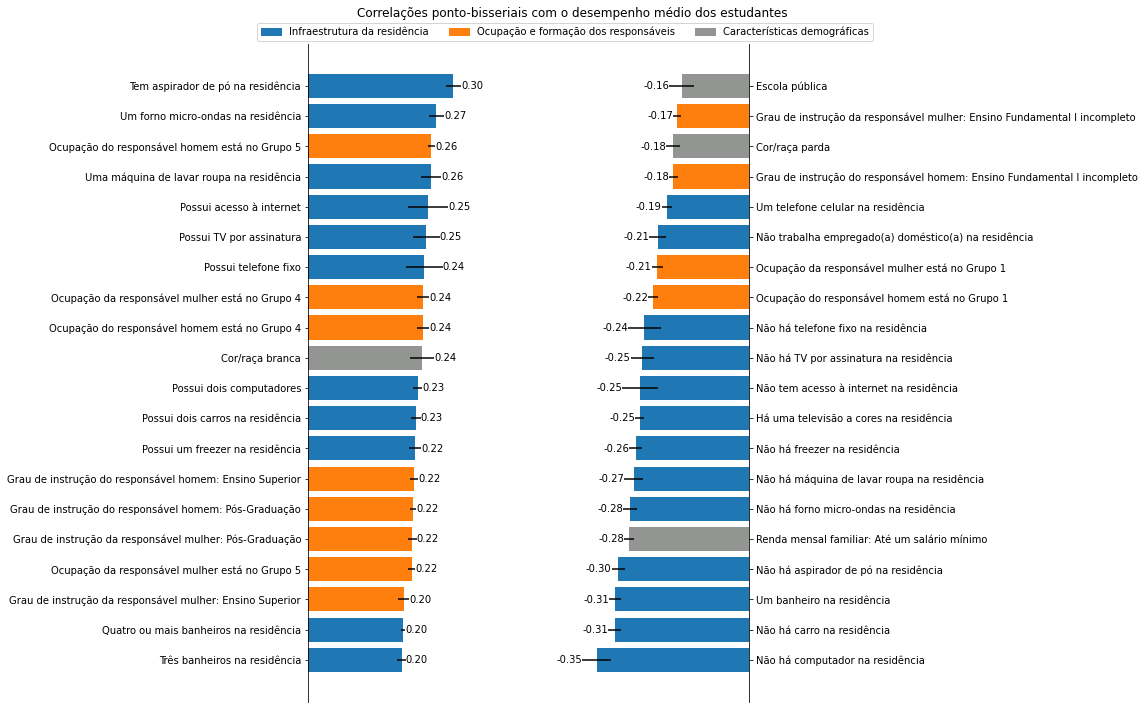

In [70]:
plot_correlations_with_average_score(R, n_left = 20, n_right = 20, figsize = (16,10),
                                     colors_left = ['#1f77b4','#1f77b4', '#ff7f0e', '#1f77b4',
                                                    '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e',
                                                    '#ff7f0e', '#929591','#1f77b4', '#1f77b4',
                                                    '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e',
                                                    '#ff7f0e', '#ff7f0e', '#1f77b4', '#1f77b4'], 
                                    colors_right = ['#929591', '#ff7f0e', '#929591', '#ff7f0e',
                                                    '#1f77b4','#1f77b4', '#ff7f0e', '#ff7f0e',
                                                    '#1f77b4','#1f77b4', '#1f77b4', '#1f77b4',
                                                    '#1f77b4', '#1f77b4', '#1f77b4', '#929591',
                                                    '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4'],
                                    )

The previous plot highlights the 20 highest, and lowest, correlations with studennts' average performance in ENEM between 2015 and 2022. Variables were categorized as "home infrastructure" (blue), "parents' occupation and education" (orange) and "other demographical data" (gray).

It is interesting to note that, generally, students that perform the best come from households with better infrastructure and whose parents usually had access to Higher Education, whereas also holding overall better-paid professions ("Grupo 5"). Almost the opposite could be stated for the negative correlations, which are associated to worse scores on the exam.

To get the whole picture, the graph that follows is the default for "plot_correlations_with_average_score()", which encompassess all variables in the original database.

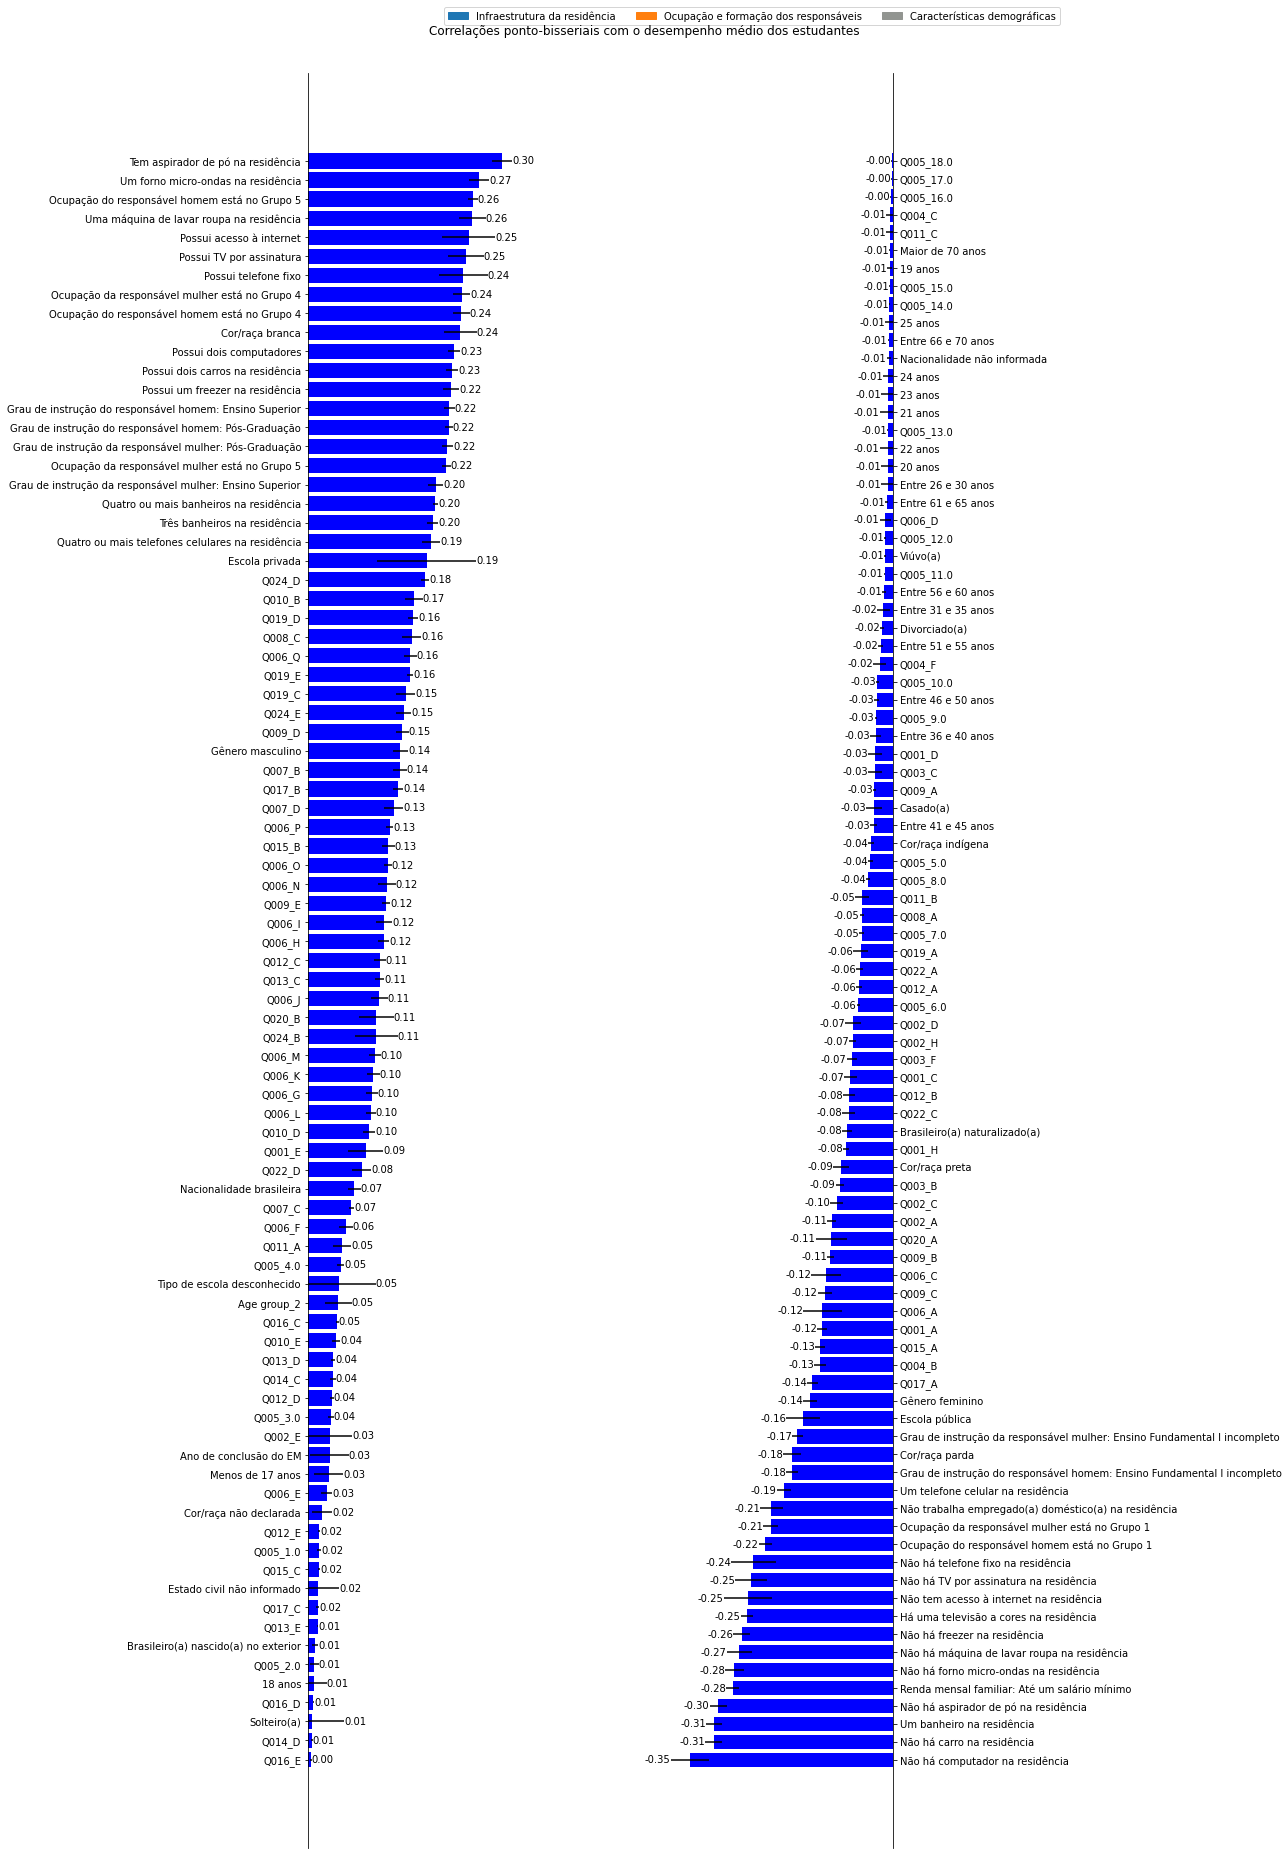

In [71]:
# Default plot - all variables
plot_correlations_with_average_score(R)

#### A special focus on correlation with family income

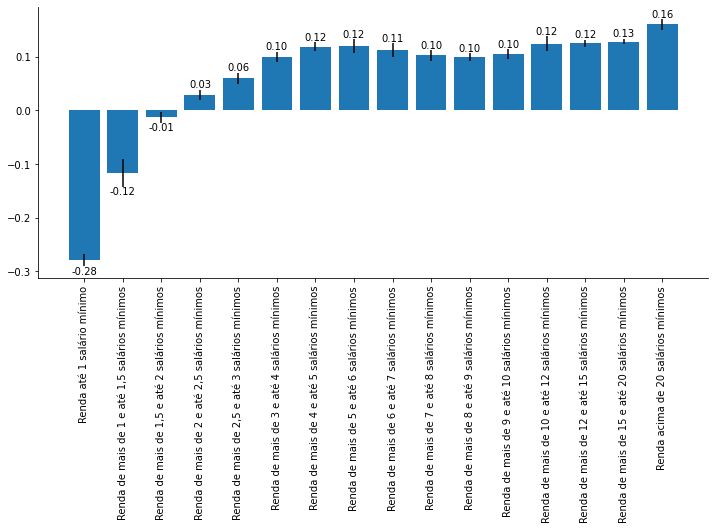

In [107]:
# Plot for correlations with family income
_, ax = plt.subplots(1,1, figsize = (12,5))

income_entries = R.filter(like='Renda', axis=0) # get only entries related to family income

values_to_plot = income_entries.mean(axis = 1)
values_to_plot_err = income_entries.std(axis = 1)
x_pos = np.arange(0, len(values_to_plot))

hbars = ax.bar(x = x_pos, height = values_to_plot, yerr = values_to_plot_err)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(x_pos, labels = values_to_plot.index, rotation = 90)
ax.bar_label(hbars, fmt = '%.2f');

In [111]:
# Saving to work with data on external tools, if needed
income_entries.to_csv("./variables_results/correlations_income.csv")

In [236]:
enem_df.columns

Index(['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
       'High school conclusion year', 'School type', 'UF', 'SG_UF_PROVA',
       'Natural Sciences score', 'Humanities score', 'Languages score',
       'Math score', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007',
       'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025',
       'Average score', 'ENEM_year'],
      dtype='object')

In [242]:
income_and_performance_df = enem_df[["Q006", "Average score", "ENEM_year"]]

<AxesSubplot: xlabel='Q006', ylabel='Average score'>

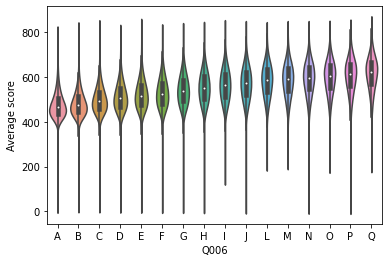

In [245]:
sns.violinplot(data = income_and_performance_df,
            x = "Q006",
            y = "Average score",
            order = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "L", "M", "N", "O", "P", "Q"])

In [263]:
del enem_df

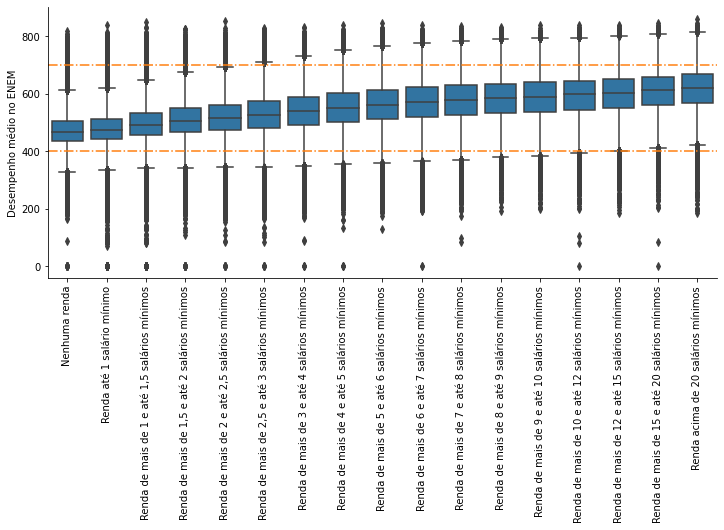

In [262]:
income_dict = {'A': 'Nenhuma renda',
    'B': 'Renda até 1 salário mínimo',
    'C': 'Renda de mais de 1 e até 1,5 salários mínimos',
    'D': 'Renda de mais de 1,5 e até 2 salários mínimos',
    'E': 'Renda de mais de 2 e até 2,5 salários mínimos',
    'F': 'Renda de mais de 2,5 e até 3 salários mínimos',
    'G': 'Renda de mais de 3 e até 4 salários mínimos',
    'H': 'Renda de mais de 4 e até 5 salários mínimos',
    'I': 'Renda de mais de 5 e até 6 salários mínimos',
    'J': 'Renda de mais de 6 e até 7 salários mínimos',
    'K': 'Renda de mais de 7 e até 8 salários mínimos',
    'L': 'Renda de mais de 8 e até 9 salários mínimos',
    'M': 'Renda de mais de 9 e até 10 salários mínimos',
    'N': 'Renda de mais de 10 e até 12 salários mínimos',
    'O': 'Renda de mais de 12 e até 15 salários mínimos',
    'P': 'Renda de mais de 15 e até 20 salários mínimos',
    'Q': 'Renda acima de 20 salários mínimos'}

_, ax = plt.subplots(1, 1, figsize = (12,5))

sns.boxplot(data = income_and_performance_df,
            x = "Q006",
            y = "Average score",
            order = income_dict.keys(),
            ax = ax,
            color = '#1f77b4')

ax.set_ylabel("Desempenho médio no ENEM")
ax.set_xlabel("")
ax.set_xticks(np.arange(0,17), labels = income_dict.values(), rotation = 90)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# plot horizontal reference lines
plot_ref_line = lambda values: values[3].hlines(y = values[0], xmin = values[1], xmax = values[2], colors = '#ff7f0e', linestyles = '-.')
plot_ref_line((400, -0.5, 16.5, ax))
plot_ref_line((700, -0.5, 16.5, ax))

___
### 2.2 Correlations with external factors

In the previous section, we analyzed correlations with the original variables in INEP databases, only. Now, let us also evaluate correlations with the external variables.

#### 2.2.1. Preliminary tests

In [8]:
years_in_siope = siope_df['year'].unique()
years_in_siope.sort()

In [9]:
years_in_siope

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022])

Unfortunately, we don't have information about every metric for every year and state, as indicated by the draft visualization that follows.

<AxesSubplot: xlabel='metric_code', ylabel='year'>

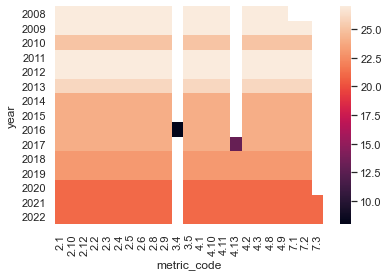

In [317]:
sns.heatmap(siope_df.groupby(["year", "metric_code"])["metric_code"].count().unstack())

To continue with the analysis, we will define time-windows of varying length that should yield average values for SIOPE's metrics, per each state of the country, that will subsequently be used for correlation analysis.

#### 2.2.2. Correlations using time-windows

##### 2.2.2.1. Correcting data by inflation

For each year students took participated in the ENEM, let us calculate the correlations with these variables and their average score in the test, using a time window to analyze whether we can spot correlation patterns changes overtime.

Prior to calculating the correlations, though, we will need to appropriately consider inflation in the budget indices values. To do this, we will use the IPCA metric and apply the methodology described [here](https://www.ibge.gov.br/explica/inflacao.php#:~:text=O%20valor%20corrigido%20%C3%A9%20obtido,do%20IPCA%20no%20per%C3%ADodo%20desejado.) for inflation correction.

This correction is performed to account for naturally expected increases in Educational budget throughout the years. By doing so, we can get a better estimate of the actual increase/decrease in these metrics, when inflaction is factored in.

In [179]:
# Reading inflation data
ipca_df = pd.read_excel("../Datasets/ipca-series.xlsx")

# Seeing the structure of ipca_df
ipca_df.head()

year  month    value  correction_factor
0  2007     12  2731.62                NaN
1  2008      1  2746.37           1.005400
2  2008     12  2892.86           1.059027
3  2009      1  2906.74           1.064108
4  2009     12  3017.59           1.104689

We will correct only metrics that hold absolute values, indicating total amount of Brazilian Real (BRL). Metrics indicating ratios will not be corrected by inflation, as they already constitute relative metrics for each year.

In [266]:
# Correcting metrics by inflation, when necessary
metrics_to_correct = ['EB_non_teaching_staff_per_student_expanses', 'courseware_investment', 'EI_investment_per_student', 'EF_investment_per_student', 'EM_investment_per_student',
                      'EB_investment_per_student', 'investment_per_student', 'EB_expanses_teacher_per_student', 'FUNDEB_balance', 'superavit_or_deficit', 'FUNDEB_not_used',
                      'average_teacher_expanses_EB']

siope_df_corrected = siope_df.copy()
for metric in metrics_to_correct:
    for uf in siope_df.UF.unique():
        for year in siope_df.year.unique():
            try:
                correction_factor = ipca_df[(ipca_df["year"] == year) & (ipca_df["month"] == 1)]["correction_factor"].values
                index_to_alter = siope_df_corrected[(siope_df_corrected["year"] == year) & (siope_df_corrected["UF"] == uf) & (siope_df_corrected["metric_description"] == metric)].index[0]
                siope_df_corrected.loc[index_to_alter, "metric_value"] = (1/correction_factor)* siope_df.loc[index_to_alter, "metric_value"]
            except:
                # just so the code won't break for missing data
                pass

In [279]:
siope_df[siope_df["metric_description"] == metric]

year metric_code  metric_value  UF               metric_description
16    2008        4.10       1361.05  RO  EB_expanses_teacher_per_student
34    2009        4.10       1333.05  RO  EB_expanses_teacher_per_student
54    2011        4.10       2186.35  RO  EB_expanses_teacher_per_student
74    2012        4.10       1725.20  RO  EB_expanses_teacher_per_student
88    2013        4.10       2046.31  RO  EB_expanses_teacher_per_student
...    ...         ...           ...  ..                              ...
7304  2013        4.10       6533.58  DF  EB_expanses_teacher_per_student
7334  2014        4.10       2441.82  DF  EB_expanses_teacher_per_student
7354  2015        4.10       6647.85  DF  EB_expanses_teacher_per_student
7374  2016        4.10       5272.71  DF  EB_expanses_teacher_per_student
7380  2017        4.10       6938.37  DF  EB_expanses_teacher_per_student

[364 rows x 5 columns]

In [286]:
df

year metric_code  metric_value  UF               metric_description  \
16    2008        4.10   1361.050000  RO  EB_expanses_teacher_per_student   
34    2009        4.10   1333.050000  RO  EB_expanses_teacher_per_student   
54    2011        4.10   2186.350000  RO  EB_expanses_teacher_per_student   
74    2012        4.10   1725.200000  RO  EB_expanses_teacher_per_student   
88    2013        4.10   2046.310000  RO  EB_expanses_teacher_per_student   
...    ...         ...           ...  ..                              ...   
7304  2013        4.10   4911.945099  DF  EB_expanses_teacher_per_student   
7334  2014        4.10   1738.655121  DF  EB_expanses_teacher_per_student   
7354  2015        4.10   4418.130509  DF  EB_expanses_teacher_per_student   
7374  2016        4.10   3165.343310  DF  EB_expanses_teacher_per_student   
7380  2017        4.10   3953.605194  DF  EB_expanses_teacher_per_student   

                is_corrected  
16    Sem correção pelo IPCA  
34    Sem correção pelo IPCA  
54    Sem correção pelo IPCA  
74    Sem correção pelo IPCA  
88    Sem correção pelo IPCA  
...                      ...  
7304                     NaN  
7334                     NaN  
7354                     NaN  
7374                     NaN  
7380                     NaN  

[728 rows x 6 columns]

In [328]:
ipca_df

year  month    value  correction_factor
0   2007     12  2731.62                NaN
1   2008      1  2746.37           1.005400
2   2008     12  2892.86           1.059027
3   2009      1  2906.74           1.064108
4   2009     12  3017.59           1.104689
5   2010      1  3040.22           1.112973
6   2010     12  3195.89           1.169961
7   2011      1  3222.42           1.179674
8   2011     12  3403.73           1.246048
9   2012      1  3422.79           1.253026
10  2012     12  3602.46           1.318800
11  2013      1  3633.44           1.330141
12  2013     12  3815.39           1.396750
13  2014      1  3836.37           1.404430
14  2014     12  4059.86           1.486246
15  2015      1  4110.20           1.504675
16  2015     12  4493.17           1.644874
17  2016      1  4550.23           1.665762
18  2016     12  4775.70           1.748303
19  2017      1  4793.85           1.754948
20  2017     12  4916.46           1.799833
21  2018      1  4930.72           1.805053
22  2018     12  5100.61           1.867247
23  2019      1  5116.93           1.873222
24  2019     12  5320.25           1.947654
25  2020      1  5331.42           1.951743
26  2020     12  5560.59           2.035638
27  2021      1  5574.49           2.040727
28  2021     12  6120.04           2.240443
29  2022      1  6153.09           2.252542
30  2022     12  6474.09           2.370055

In [334]:
df["year"].unique().sort()

<ipython-input-351-69600f1eae27>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Correção pelo IPCA"] = "Sem correção"


Text(0, 0.5, 'Fator de correção')

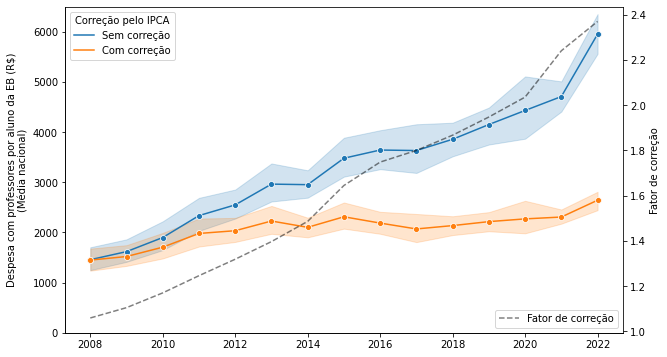

In [351]:
# plot IPCA correction comparison
_, ax = plt.subplots(1,1,figsize = (10,6))

metric = 'EB_expanses_teacher_per_student'

df = siope_df[siope_df["metric_description"] == metric]
df["Correção pelo IPCA"] = "Sem correção"
df = pd.concat([df, siope_df_corrected[siope_df_corrected["metric_description"] == metric]], axis = 0)
df["Correção pelo IPCA"].fillna("Com correção", inplace = True)

sns.lineplot(data = df,
             x = "year",
             y = "metric_value",
             hue = "Correção pelo IPCA",
             marker = 'o')

ax.set_xlabel("")
ax.set_ylabel("Despesa com professores por aluno da EB (R$)\n(Média nacional)")
ax.set_ylim([0, 6500])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax2 = ax.twinx()
ipca_values_to_plot = ipca_df[(ipca_df["month"] == 12) & (ipca_df["year"] > 2007)]["correction_factor"]
ax2.plot(df["year"].sort_values().unique(), ipca_values_to_plot, '--k', alpha = 0.5)
ax2.legend(["Fator de correção"], loc = "lower right")
ax2.set_ylabel("Fator de correção")

In [269]:
siope_df_corrected.head()

year metric_code  metric_value  UF  \
0  2008         2.1       0.00000  RO   
1  2008        4.11      62.16433  RO   
2  2008         2.3       0.00000  RO   
3  2008         2.4       0.00000  RO   
4  2008         2.5      78.36000  RO   

                           metric_description  
0                             EI_FUNDEB_ratio  
1  EB_non_teaching_staff_per_student_expanses  
2                             EM_FUNDEB_ratio  
3              EI_to_total_education_expanses  
4              EF_to_total_education_expanses

In [166]:
# To show important information in the graphs in Portuguese
siope_dict_pt = {
    'superavit_or_deficit': "Superávit/Déficit da UF",
    "investment_per_student": "Investimento por estudante",
    "FUNDEB_balance": "Saldo financeiro do FUNDEB",
    "EB_expanses_teacher_per_student": "Despesa com professores por aluno da EB",
    "EB_non_teaching_staff_per_student_expanses": "Despesa com pessoal não docente por aluno da EB",
    "education_to_overall_expanses": "Fração de despesas com Educação"
}

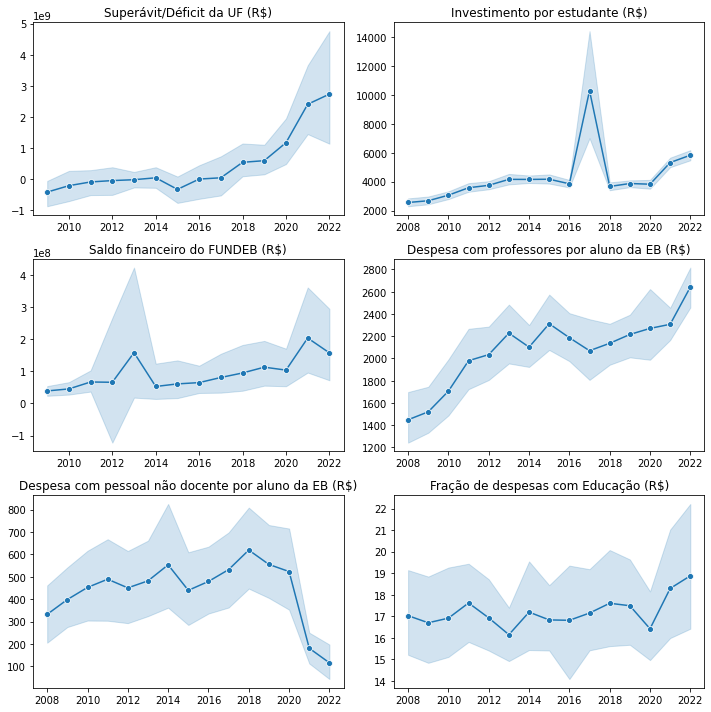

In [201]:
metrics_to_plot = ["superavit_or_deficit", "investment_per_student", "FUNDEB_balance", "EB_expanses_teacher_per_student", "EB_non_teaching_staff_per_student_expanses", "education_to_overall_expanses"]
fig, ax = plt.subplots(3,2, figsize = (10,10))
ax = np.reshape(ax, (1,6))

#plt.suptitle("Correlações entre indicadores orçamentários educacionais e desempenho médio no ENEM")

i = 0
for metric in metrics_to_plot:
    sns.lineplot(data = siope_df_corrected[siope_df_corrected["metric_description"] == metric],
             x = "year",
             y = "metric_value",
             marker = 'o',
             ax = ax[0,i])
    
    ax[0,i].set_xlabel("")
    ax[0,i].set_ylabel("")
    ax[0,i].set_title(f"{siope_dict_pt[metric]} (R$)")
    #ax[0,i].set_ylim(bottom = -10)
    i += 1

plt.tight_layout()

##### 2.2.2.2. Correlation calculations

In [203]:
def merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_data, enem_data, current_year):
    metrics_added = []
    df2 = enem_data[enem_data["ENEM_year"] == current_year][["UF", "Average score", "Natural Sciences score"]].copy()

    for metric in SIOPE_METRICS_DICT.values():
        try:
            df2 = df2.merge(grouped_siope_data[metric], how = 'left', on = 'UF')
            metrics_added.append(metric)
        except:
            df2 = df2
    
    return df2

In [204]:
def reformat_external_siope_correlations(siope_correlations_data):
    siope_correlations_data.reset_index(inplace = True)
    siope_correlations_data.rename(columns = {"index": "metric"}, inplace = True)
    formatted_data = pd.DataFrame()
    i = 0
    for metric in siope_correlations_data['metric'].unique():
        aux_df = siope_correlations_data[siope_correlations_data['metric'] == metric][['window', 'Average score']]
        aux_df.rename(columns = {"Average score": metric}, inplace = True)

        if i == 0:
            formatted_data = pd.concat([formatted_data, aux_df], axis = 1)
        else:
            formatted_data = formatted_data.merge(aux_df, on = 'window', how = 'left')
        i += 1
    return formatted_data

In [7]:
def run_longitudinal_correlation_analysis(years_to_analyze, time_window):
    R_external_all_years = {}
    for year in years_to_analyze:
        R_external = pd.DataFrame()
        print(f"Running analysis for ENEM {year}")
        for window in n:
            print(f"Running for the last {window} year(s)")
            # get metrics average values over last 'window' years
            grouped_siope_df = siope_df[(siope_df['year'] >= year - window)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

            siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)
            r = siope_data_with_scores_df.corr(method = 'spearman', numeric_only = True)
            r["window"] = window
            R_external = pd.concat([R_external, r[["Average score", "window"]]], axis = 0)

            del siope_data_with_scores_df
        joblib.dump(R_external, f"siope_correlations_ENEM_{year}.pkl")

        R_external_all_years[year] = R_external
        del R_external
    
    return R_external_all_years 
    

In [206]:
n = np.arange(0,16)

for year in years_to_analyze:
    R_external = pd.DataFrame()
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    enem_df.drop(columns = "UF", inplace = True)
    enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)
    
    for window in n:
        print(f"Running for the last {window} year(s)")
        # get metrics average values over last 'window' years
        grouped_siope_df = siope_df_corrected[
            (siope_df_corrected['year'] >= year - window) & (siope_df_corrected["year"] <= year)
            ].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()


        siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)
        r = siope_data_with_scores_df.corr(method = 'spearman', numeric_only = True)
        r["window"] = window
        R_external = pd.concat([R_external, r[["Average score", "window"]]], axis = 0)

        del siope_data_with_scores_df
    joblib.dump(R_external, f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_ipca_corrected.pkl")
    del R_external

Running analysis for ENEM 2015
Running for the last 0 year(s)
Running for the last 1 year(s)
Running for the last 2 year(s)
Running for the last 3 year(s)
Running for the last 4 year(s)
Running for the last 5 year(s)
Running for the last 6 year(s)
Running for the last 7 year(s)
Running for the last 8 year(s)
Running for the last 9 year(s)
Running for the last 10 year(s)
Running for the last 11 year(s)
Running for the last 12 year(s)
Running for the last 13 year(s)
Running for the last 14 year(s)
Running for the last 15 year(s)
Running analysis for ENEM 2016
Running for the last 0 year(s)
Running for the last 1 year(s)
Running for the last 2 year(s)
Running for the last 3 year(s)
Running for the last 4 year(s)
Running for the last 5 year(s)
Running for the last 6 year(s)
Running for the last 7 year(s)
Running for the last 8 year(s)
Running for the last 9 year(s)
Running for the last 10 year(s)
Running for the last 11 year(s)
Running for the last 12 year(s)
Running for the last 13 year(s

In [8]:
def effect_size(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [14]:
r = np.zeros((24, 24))
p = r
effect = r

for i in columns:
    print(f"Column {i}")
    for j in columns:
        r[i][j], p[i][j] = spearmanr(siope_data_with_scores_df[i],
                                             siope_data_with_scores_df[j])
        effect[i][j] = effect_size(siope_data_with_scores_df[i],
                                           siope_data_with_scores_df[j])

In [ ]:
n = np.arange(0,16)

for year in [2022]:
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    for window in [0]:
        print(f"Running for the last {window} year(s)")
        # get metrics average values over last 'window' years
        print("Grouping SIOPE data")
        grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

        print("Dropping and renaming")
        enem_df.drop(columns = "UF", inplace = True)
        enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)

        print("Merging data")
        # siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)

        siope_data_with_scores_df = enem_df[["UF", "Average score"]].merge(grouped_siope_df, on = 'UF', how = 'left')

        print("Initializing arrays")
        r = np.zeros((siope_data_with_scores_df.shape[1], siope_data_with_scores_df.shape[1]))
        p = r
        effect = r

        for i in siope_data_with_scores_df.columns:
            print(f"Column {i}")
            for j in siope_data_with_scores_df.columns:
                r[i][j], p[i][j] = spearmanr(siope_data_with_scores_df[i],
                                             siope_data_with_scores_df[j])
                effect[i][j] = effect_size(siope_data_with_scores_df[i],
                                           siope_data_with_scores_df[j])

Running analysis for ENEM 2022
Running for the last 0 year(s)
Grouping SIOPE data
Dropping and renaming
Merging data


In [35]:
siope_df["year"].min()

2008

In [ ]:
# p-values and effect size
n = np.arange(0,16)

for year in years_to_analyze:
    R_external = pd.DataFrame()
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    for window in n:=
        print(f"Running for the last {window} year(s)")
        # get metrics average values over last 'window' years
        grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

        enem_df.drop(columns = "UF", inplace = True)
        enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)
        siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)

        r = np.zeros(siope_data_with_scores_df.shape[1], siope_data_with_scores_df.shape[1])
        p = r
        effect = r

        for i in siope_data_with_scores_df.columns:
            for j in siope_data_with_scores_df.columns:
                r[i][j], p[i][j] = spearmanr(siope_data_with_scores_df[i],
                                             siope_data_with_scores_df[j])
                effect[i][j] = effect_size(siope_data_with_scores_df[i],
                                           siope_data_with_scores_df[j])

        
        r["window"] = window
        R_external = pd.concat([R_external, r[["Average score", "window"]]], axis = 0)

        del siope_data_with_scores_df
    joblib.dump(R_external, f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_v2.pkl")
    del R_external

##### Visualizaing results

###### Each year as a figure

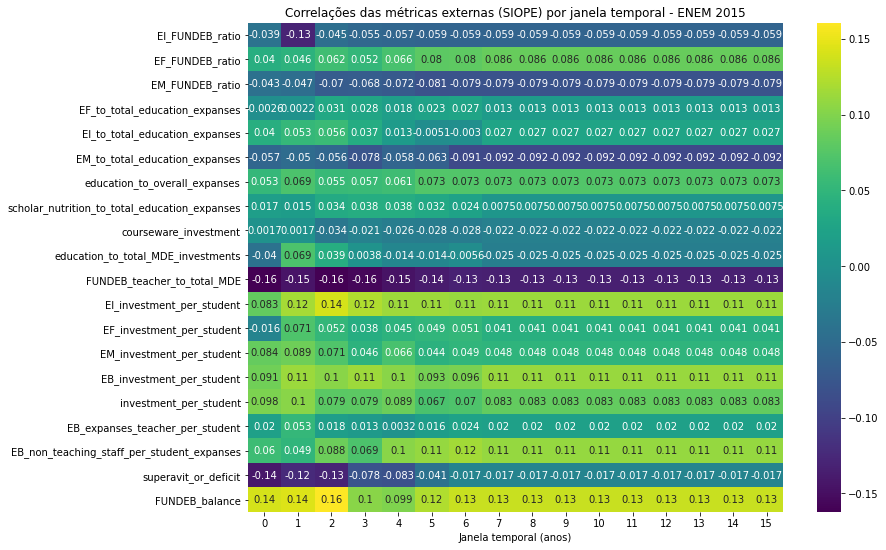

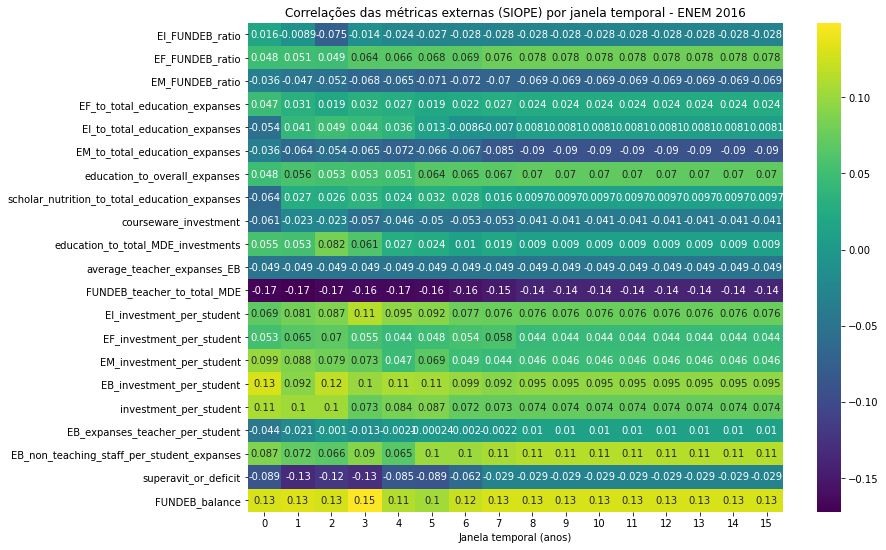

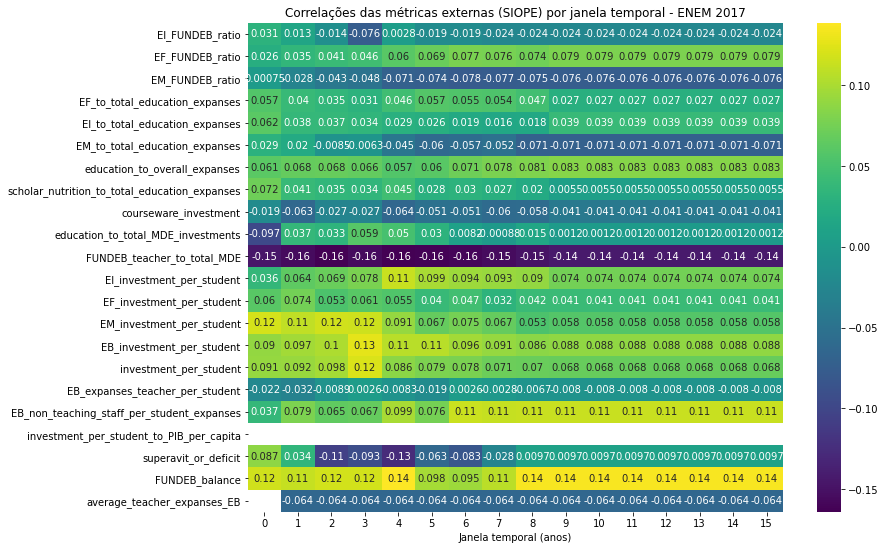

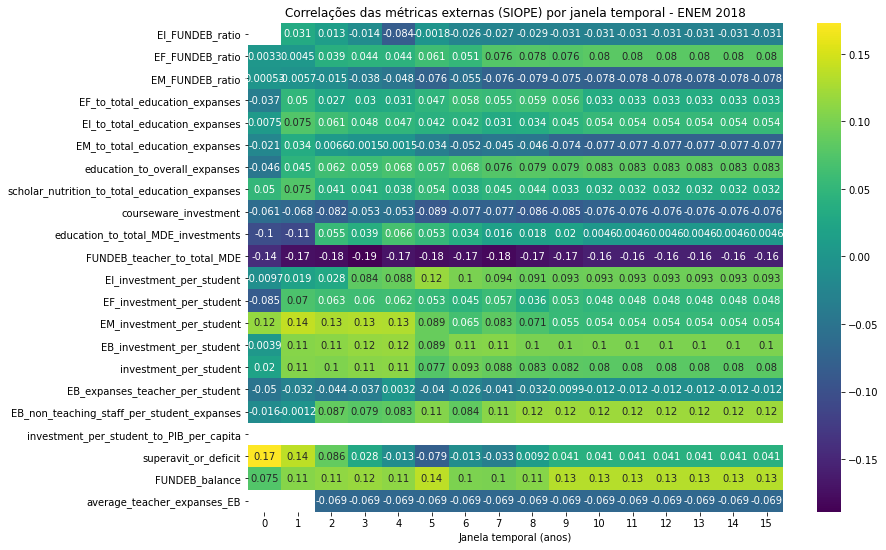

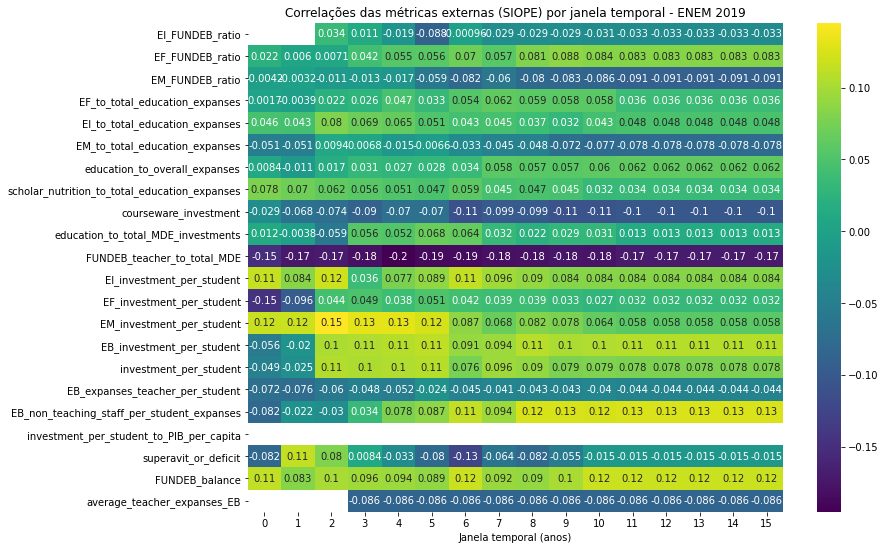

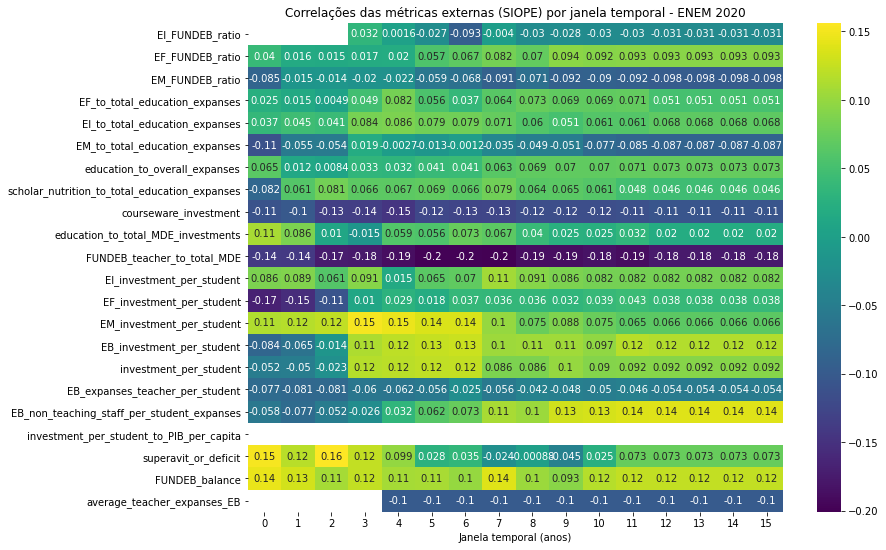

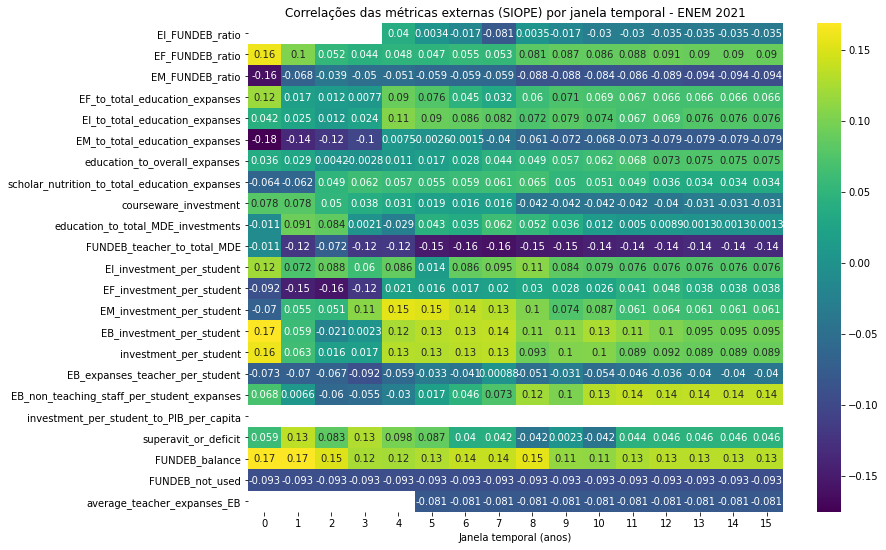

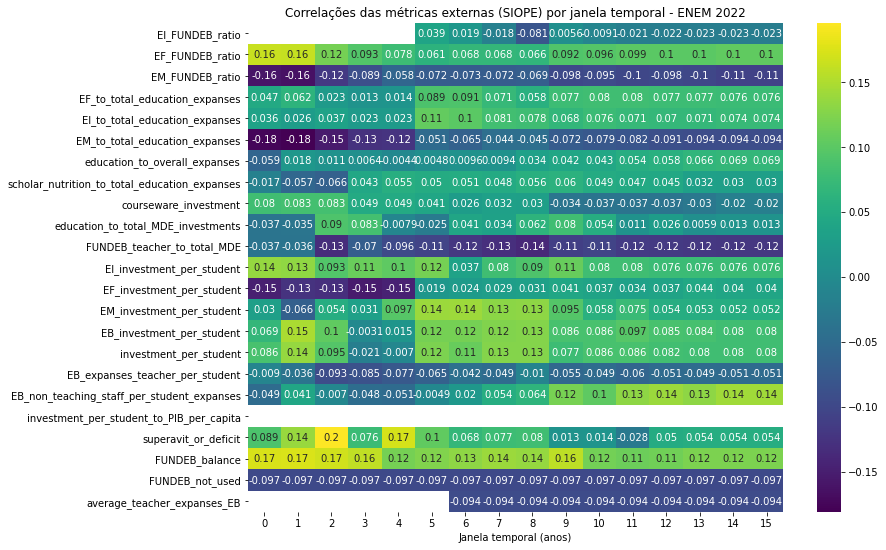

In [207]:
for year in years_to_analyze:
    R_ext = joblib.load(f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_ipca_corrected.pkl")
    R_ext = reformat_external_siope_correlations(R_ext)
    R_ext.drop(columns = ["window", "Average score", "Natural Sciences score"], inplace = True)

    plt.figure(figsize = (12,9))
    sns.heatmap(R_ext.transpose(),
    cmap = 'viridis',
    annot = True)
    plt.xlabel("Janela temporal (anos)")
    plt.title(f"Correlações das métricas externas (SIOPE) por janela temporal - ENEM {year}")
    plt.show()
del R_ext

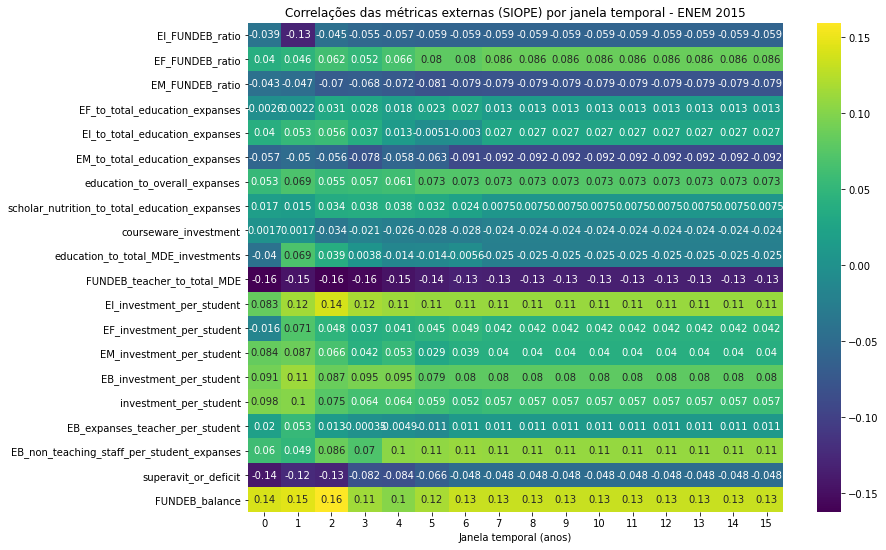

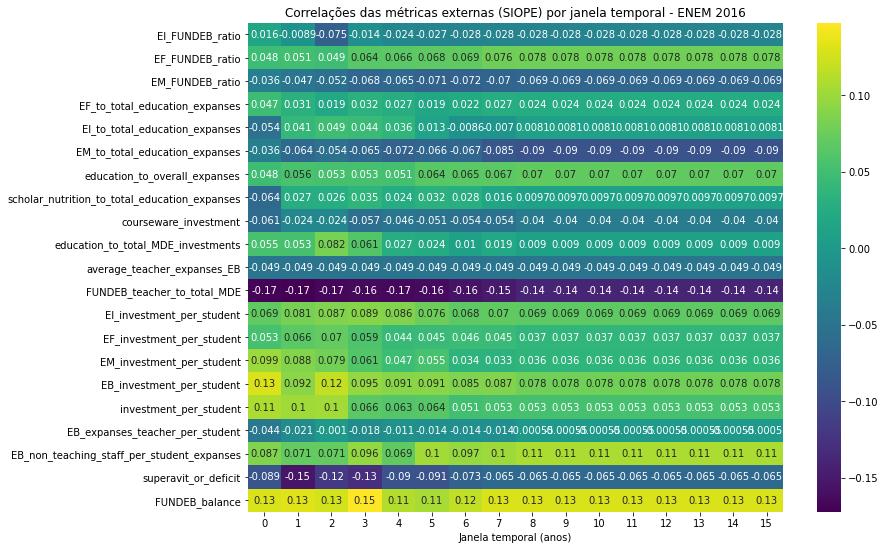

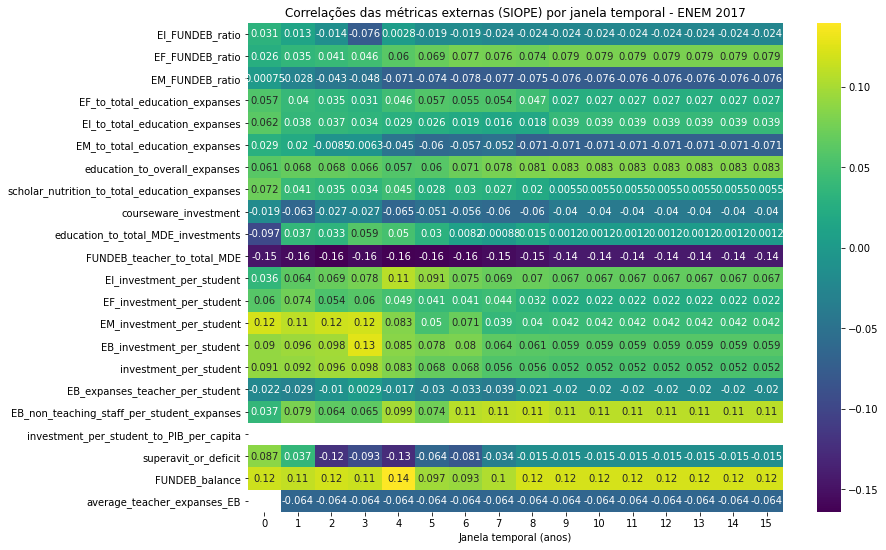

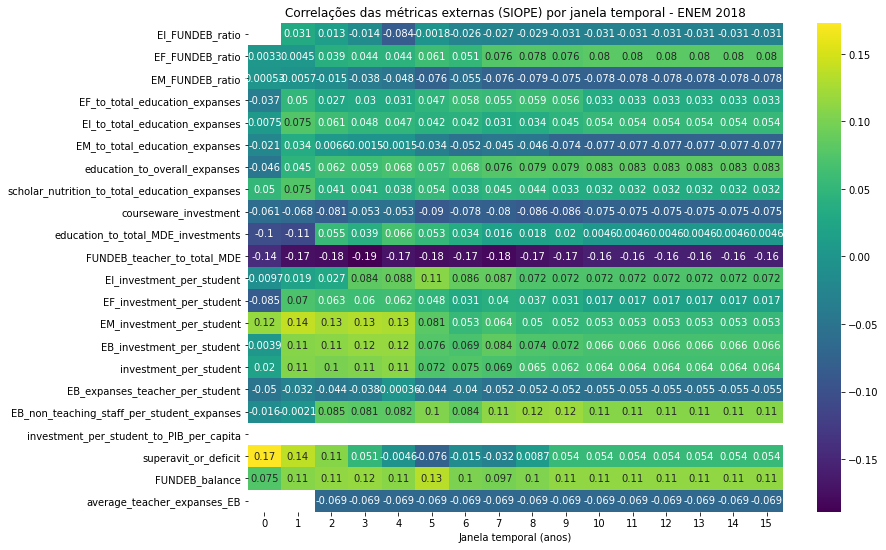

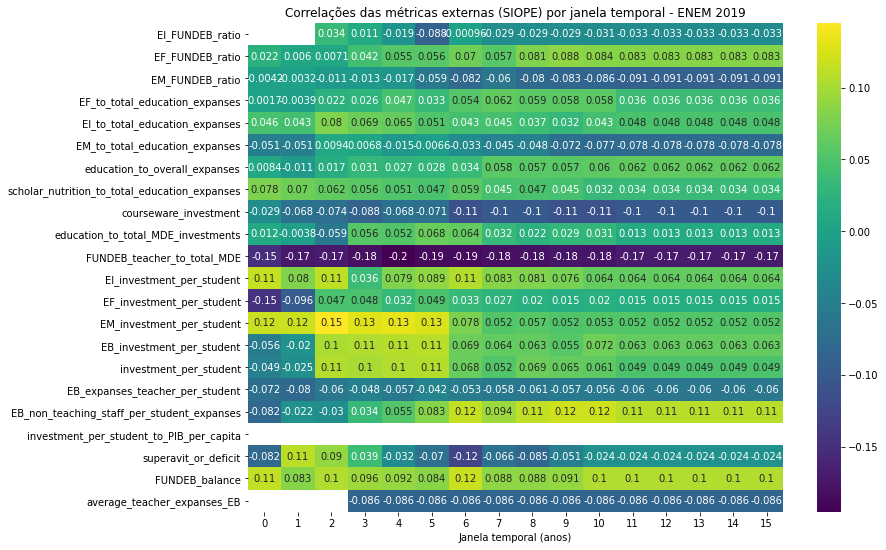

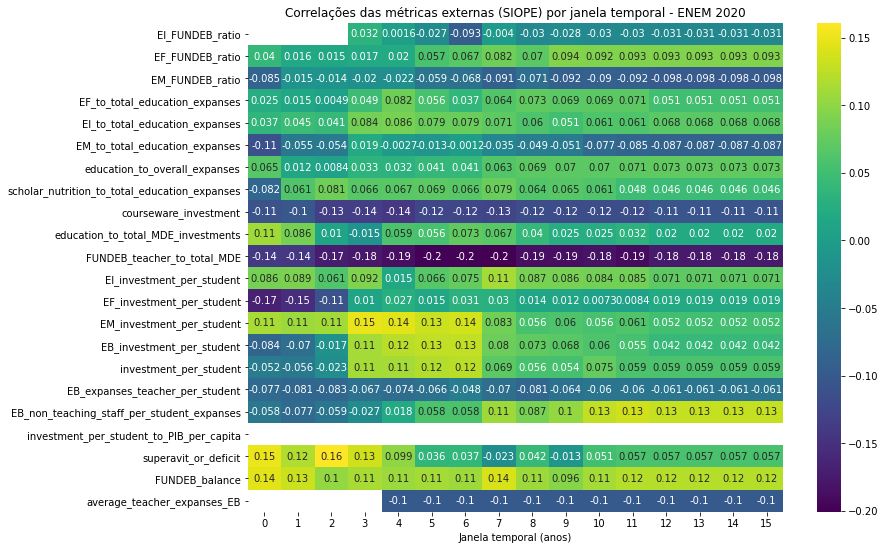

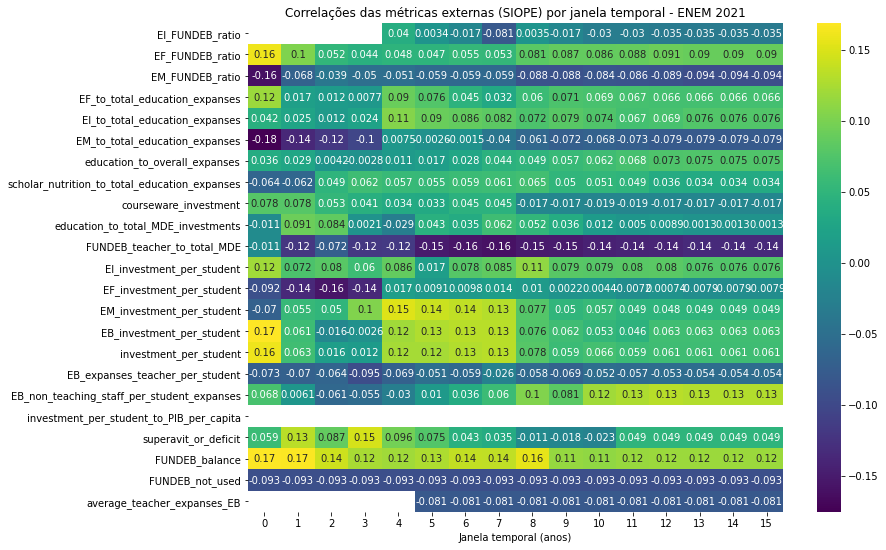

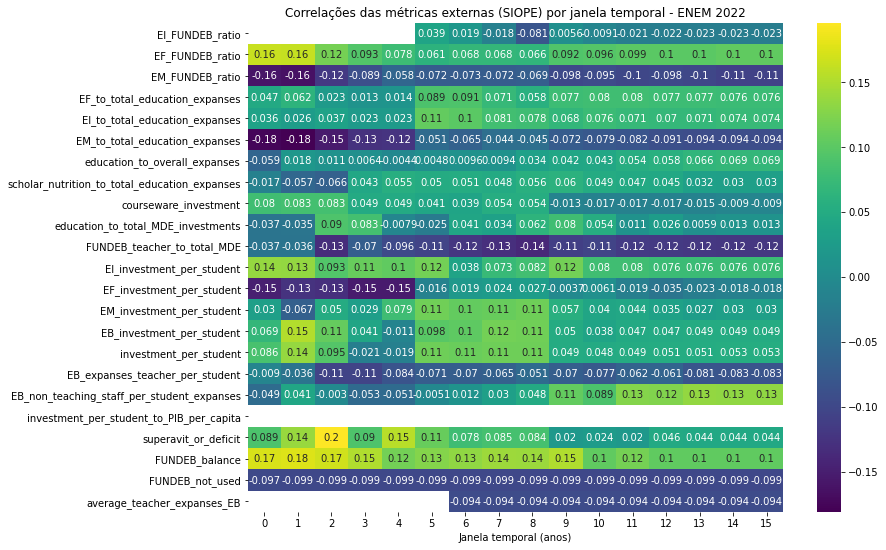

In [33]:
for year in years_to_analyze:
    R_ext = joblib.load(f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_ipca_corrected.pkl")
    R_ext = reformat_external_siope_correlations(R_ext)
    R_ext.drop(columns = ["window", "Average score", "Natural Sciences score"], inplace = True)

    plt.figure(figsize = (12,9))
    sns.heatmap(R_ext.transpose(),
    cmap = 'viridis',
    annot = True)
    plt.xlabel("Janela temporal (anos)")
    plt.title(f"Correlações das métricas externas (SIOPE) por janela temporal - ENEM {year}")
    plt.show()

In [208]:
metrics_to_use = ["EI_FUNDEB_ratio", "EF_FUNDEB_ratio", "EM_FUNDEB_ratio", "EF_to_total_education_expanses", "EI_to_total_education_expanses",
                  "EM_to_total_education_expanses", "education_to_overall_expanses", "scholar_nutrition_to_total_education_expanses",
                  "courseware_investment", "education_to_total_MDE_investments", "FUNDEB_teacher_to_total_MDE", "EI_investiment_per_student",
                  "EF_investment_per_student", "EB_investment_per_student", "EB_investment_per_student", "investment_per_student",
                  "EB_expanses_teacher_per_student", "EB_non_teaching_staff_per_student_expanses", "superavit_or_deficit", "FUNDEB_balance",
                  "FUNDEB_not_used", "avereage_teacher_expanses_EB"]

In [211]:
siope_corr_df = pd.DataFrame()
for year in years_to_analyze:
    R_ext = joblib.load(f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_ipca_corrected.pkl")
    R_ext["year"] = year

    siope_corr_df = pd.concat([siope_corr_df, R_ext], axis = 0)
del R_ext

In [212]:
siope_corr_df = siope_corr_df.reset_index().rename(columns = {"index": "metric"})

###### Each metric as a figure

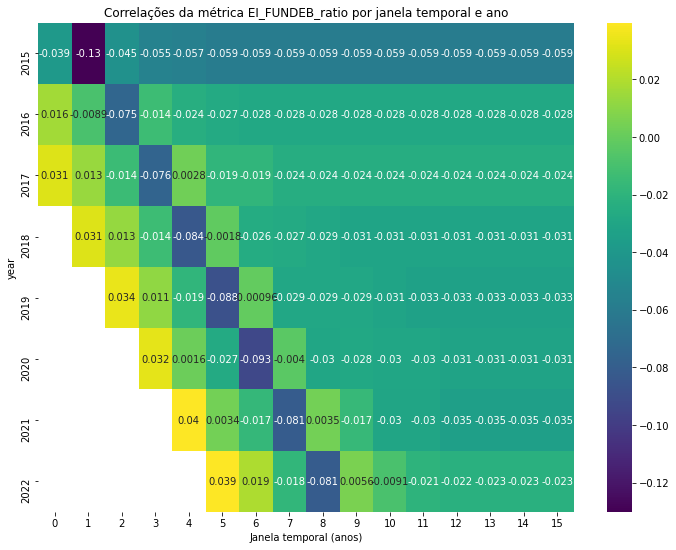

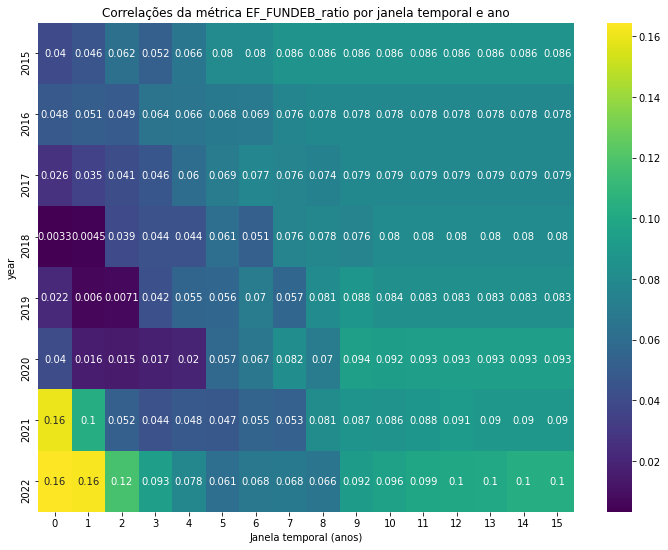

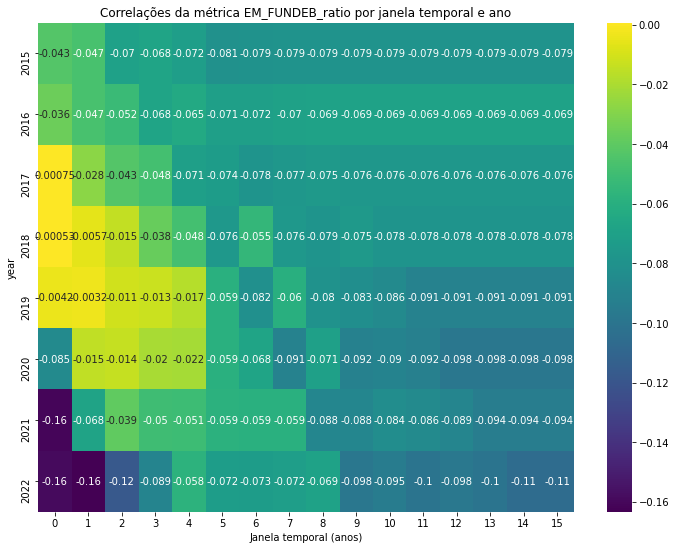

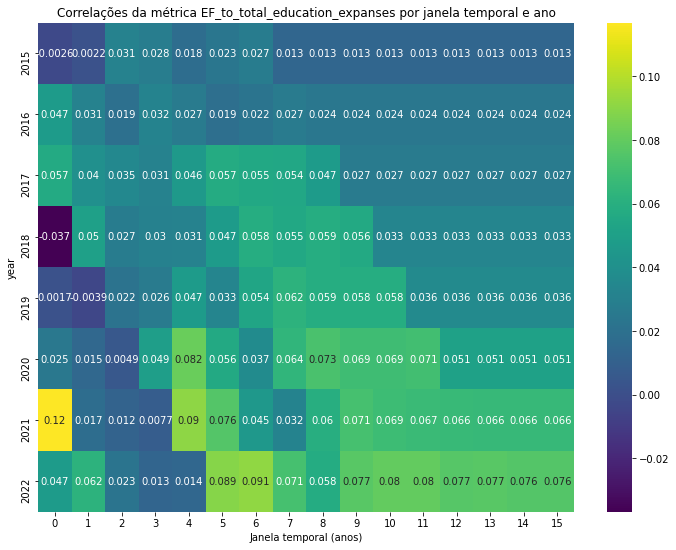

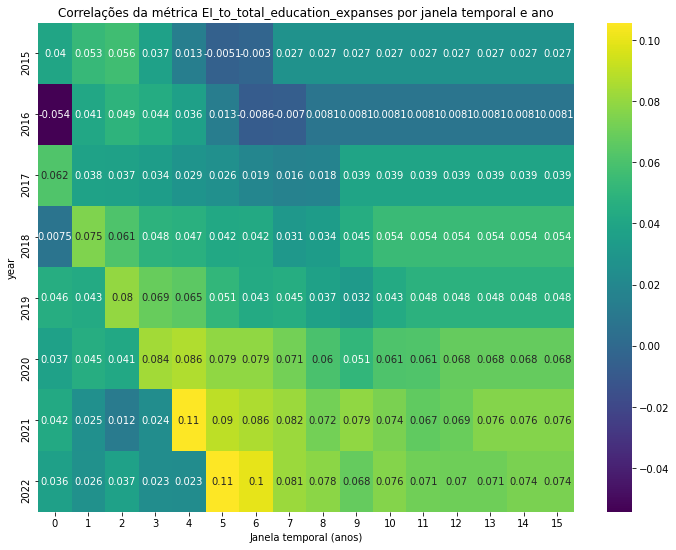

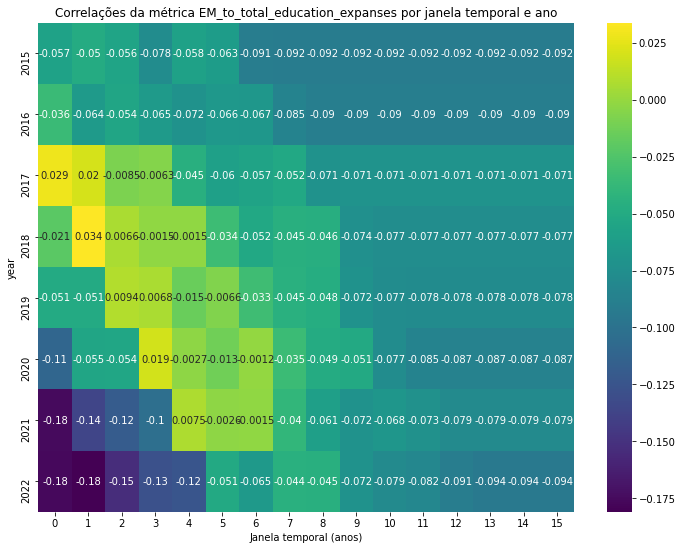

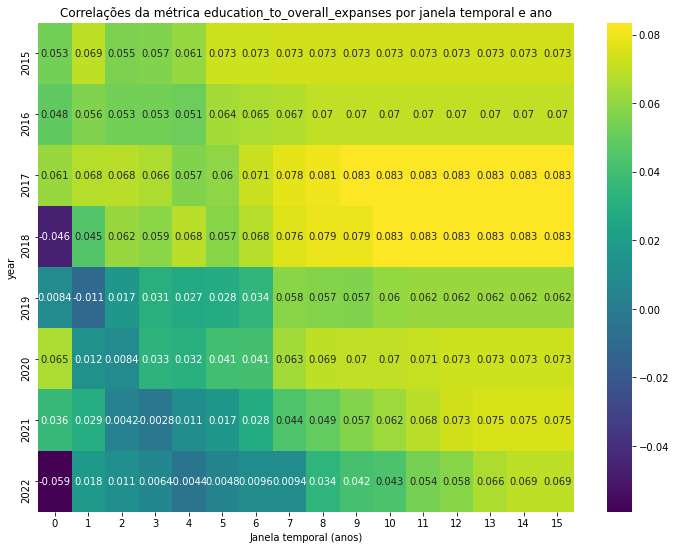

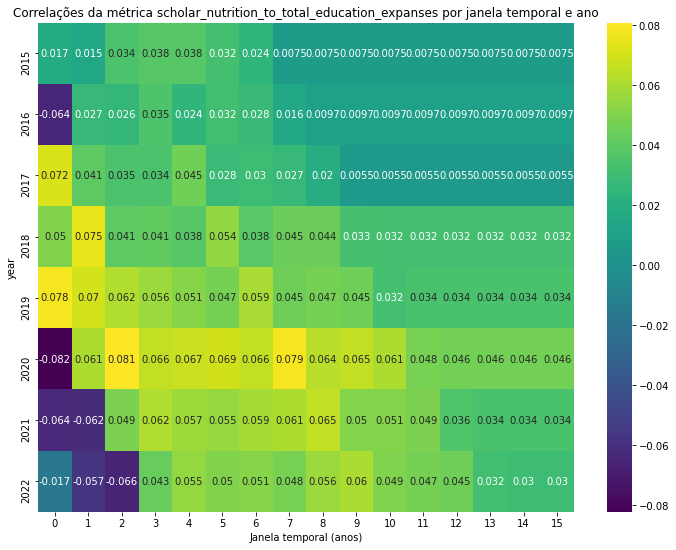

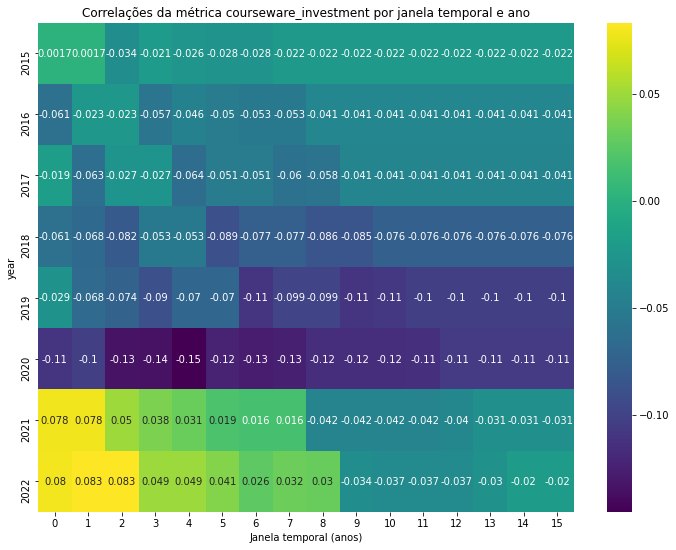

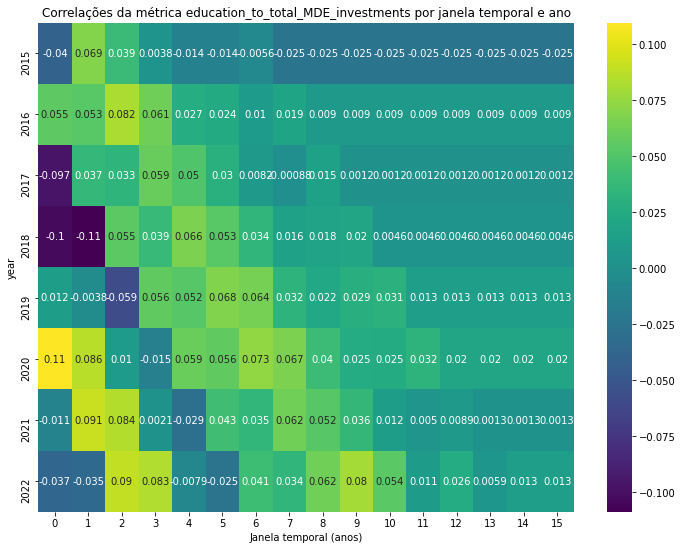

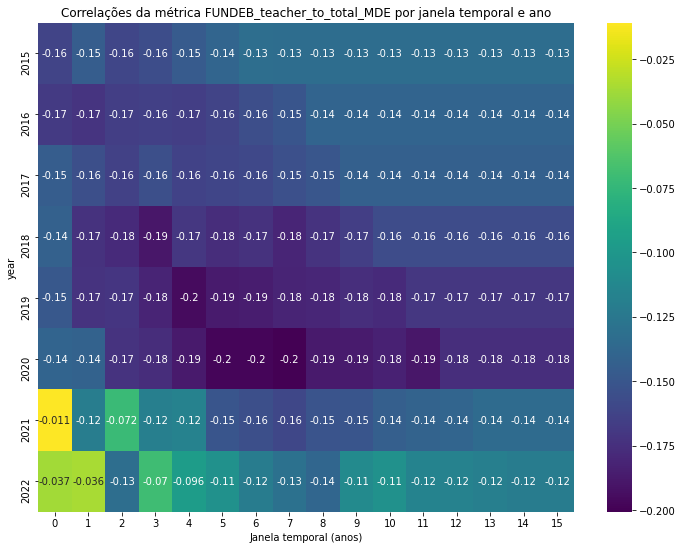

Couldn't plot for EI_investiment_per_student


<Figure size 864x648 with 0 Axes>

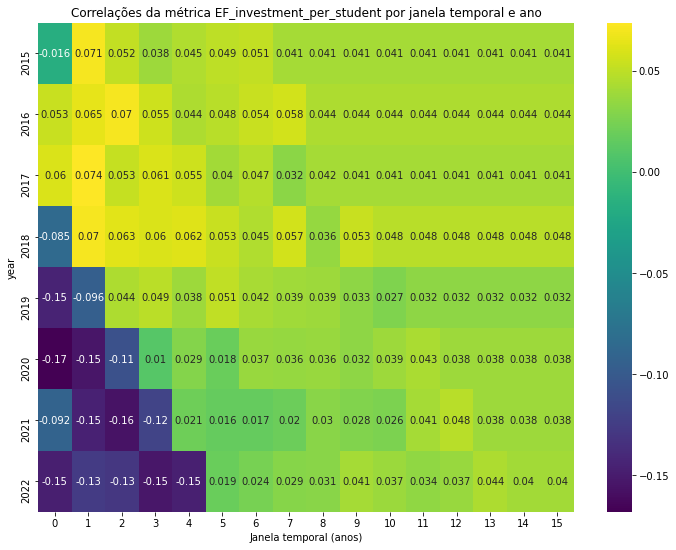

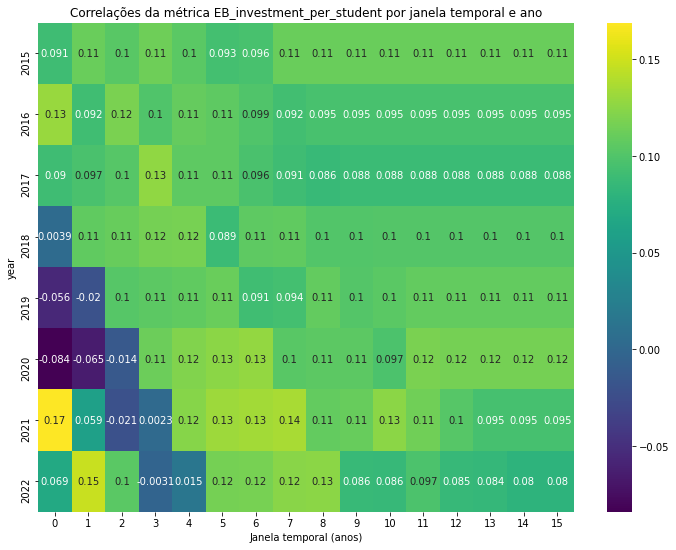

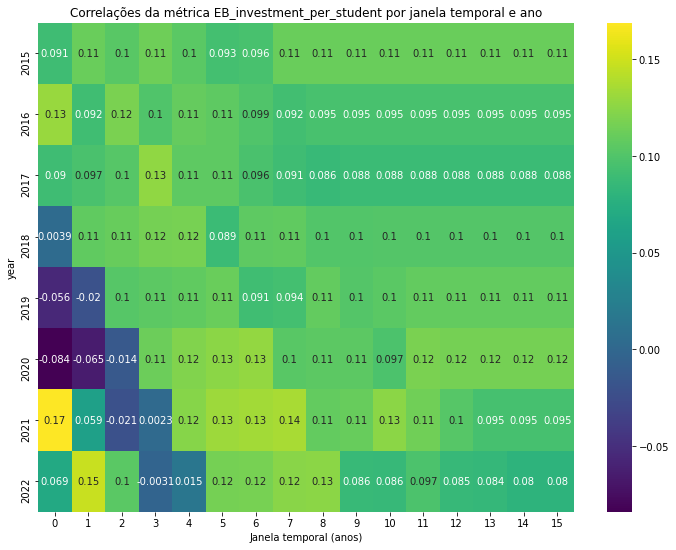

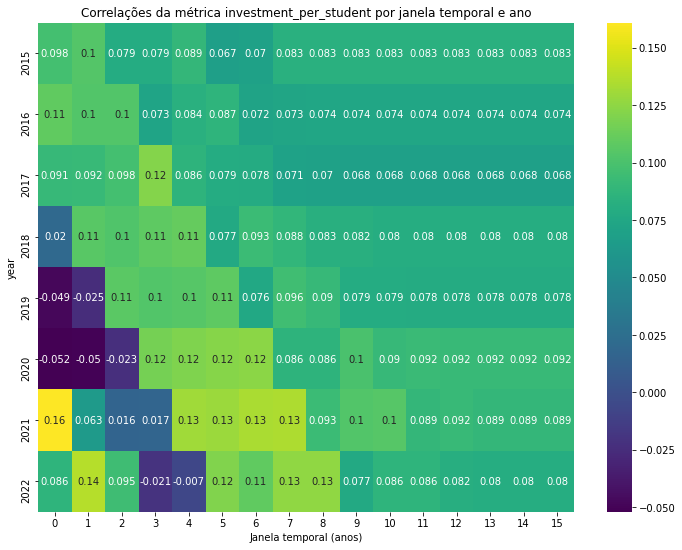

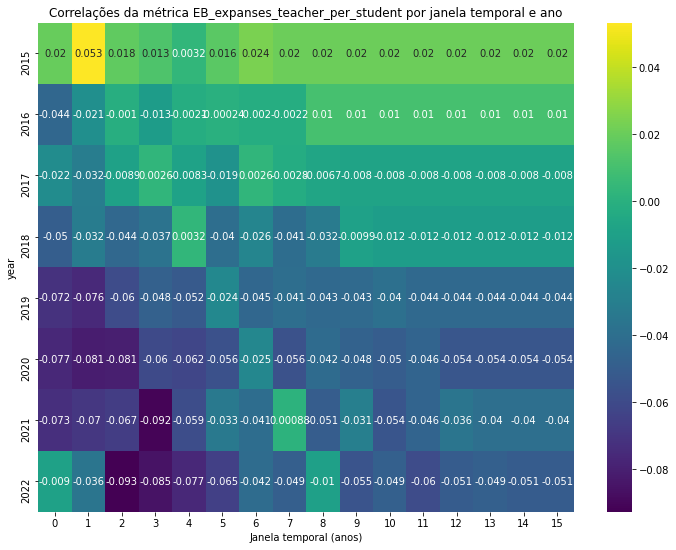

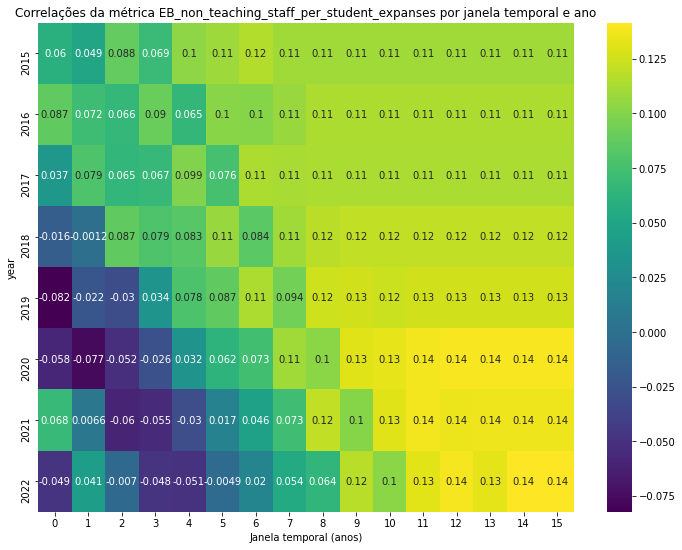

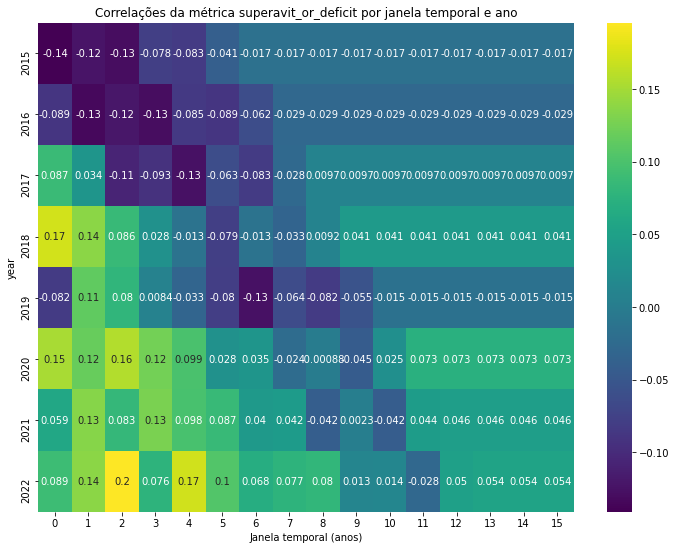

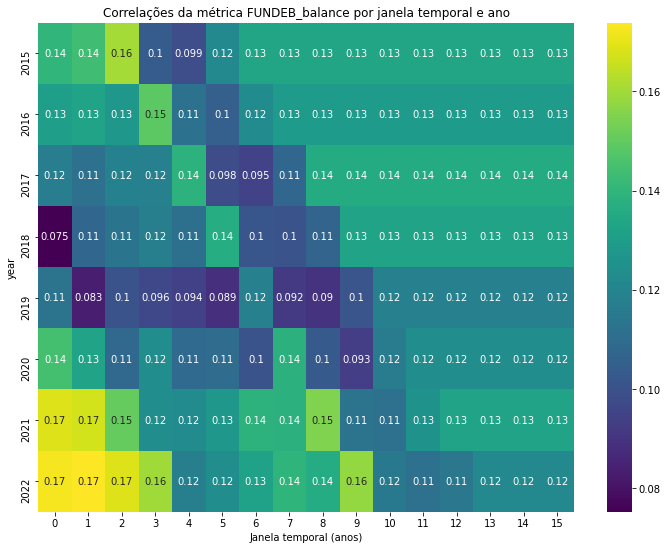

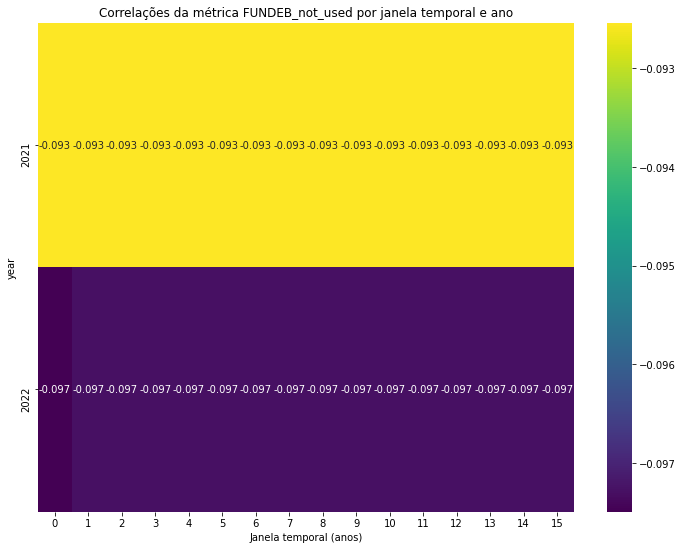

Couldn't plot for avereage_teacher_expanses_EB


<Figure size 864x648 with 0 Axes>

In [213]:
for metric in metrics_to_use:
    plt.figure(figsize = (12,9))
    df = siope_corr_df[siope_corr_df["metric"] == metric]
    try:
        sns.heatmap(df.pivot(columns = "window", index = "year", values = "Average score"), annot = True, cmap = 'viridis')
        plt.xlabel("Janela temporal (anos)")
        plt.title(f"Correlações da métrica {metric} por janela temporal e ano")
        plt.show()
    except:
        print(f"Couldn't plot for {metric}")

In [326]:
siope_dict_pt = {
    'superavit_or_deficit': "Superávit/Déficit da UF (BRL)",
    "investment_per_student": "Investimento por estudante (BRL)",
    "FUNDEB_balance": "Saldo financeiro do FUNDEB (BRL)",
    "EB_expanses_teacher_per_student": "Despesa com professores por aluno da EB (BRL)",
    "EB_non_teaching_staff_per_student_expanses": "Despesa com pessoal não docente por aluno da EB (BRL)",
    "education_to_overall_expanses": "Fração de despesas com Educação (%)",
    "scholar_nutrition_to_total_education_expanses": "Fração de despesas com nutrição educacional (%)",
    "courseware_investment": "Investimento com materiais didáticos (BRL)"
}

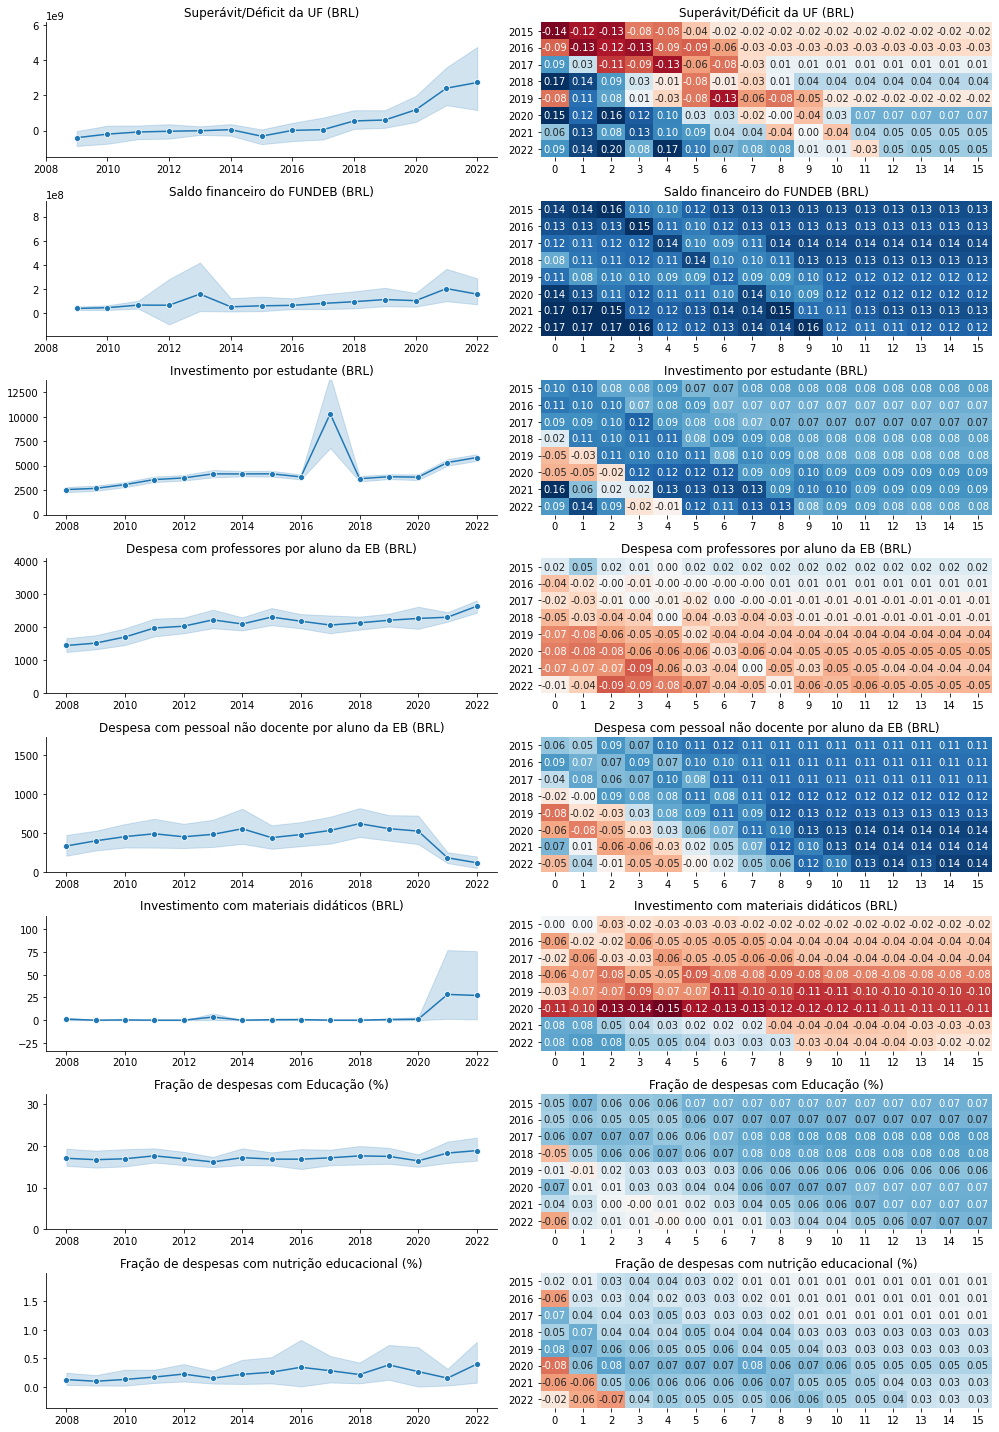

In [327]:
# Plotting heatmap and time evolution
metrics_to_plot = ["superavit_or_deficit", "FUNDEB_balance", "investment_per_student",
                   "EB_expanses_teacher_per_student", "EB_non_teaching_staff_per_student_expanses", 
                   "courseware_investment", "education_to_overall_expanses", "scholar_nutrition_to_total_education_expanses"]
fig, ax = plt.subplots(8,2, figsize = (14,20))
ax = np.reshape(ax, (1,16))

i = 0
for metric in metrics_to_plot:
    data_to_plot = siope_df_corrected[siope_df_corrected["metric_description"] == metric]
    sns.lineplot(data = data_to_plot,
             x = "year",
             y = "metric_value",
             marker = 'o',
             ax = ax[0,i])
    
    ax[0,i].set_xlabel("")
    ax[0,i].set_ylabel("")
    ax[0,i].set_ylim(
        [min(0,data_to_plot["metric_value"].mean() - 1*data_to_plot["metric_value"].std()),
         data_to_plot["metric_value"].mean() + 3*data_to_plot["metric_value"].std()
        ])
    ax[0,i].set_title(f"{siope_dict_pt[metric]}")
    ax[0,i].spines["top"].set_visible(False)
    ax[0,i].spines["right"].set_visible(False)
    ax[0,i].set_xticks(np.arange(2008,2023,2))
    i += 1
    
    
    df = siope_corr_df[siope_corr_df["metric"] == metric]
    sns.heatmap(df.pivot(columns = "window", index = "year", values = "Average score"),
                    annot = True,
                    cmap = 'RdBu',
                    ax = ax[0,i],
                    cbar = False,
                    fmt = '.2f',
                    vmin = -0.15,
                    vmax = 0.15
                    )
    ax[0,i].set_title(f"{siope_dict_pt[metric]}")
    ax[0,i].set_xlabel("")
    ax[0,i].set_ylabel("")

    i += 1

plt.tight_layout()

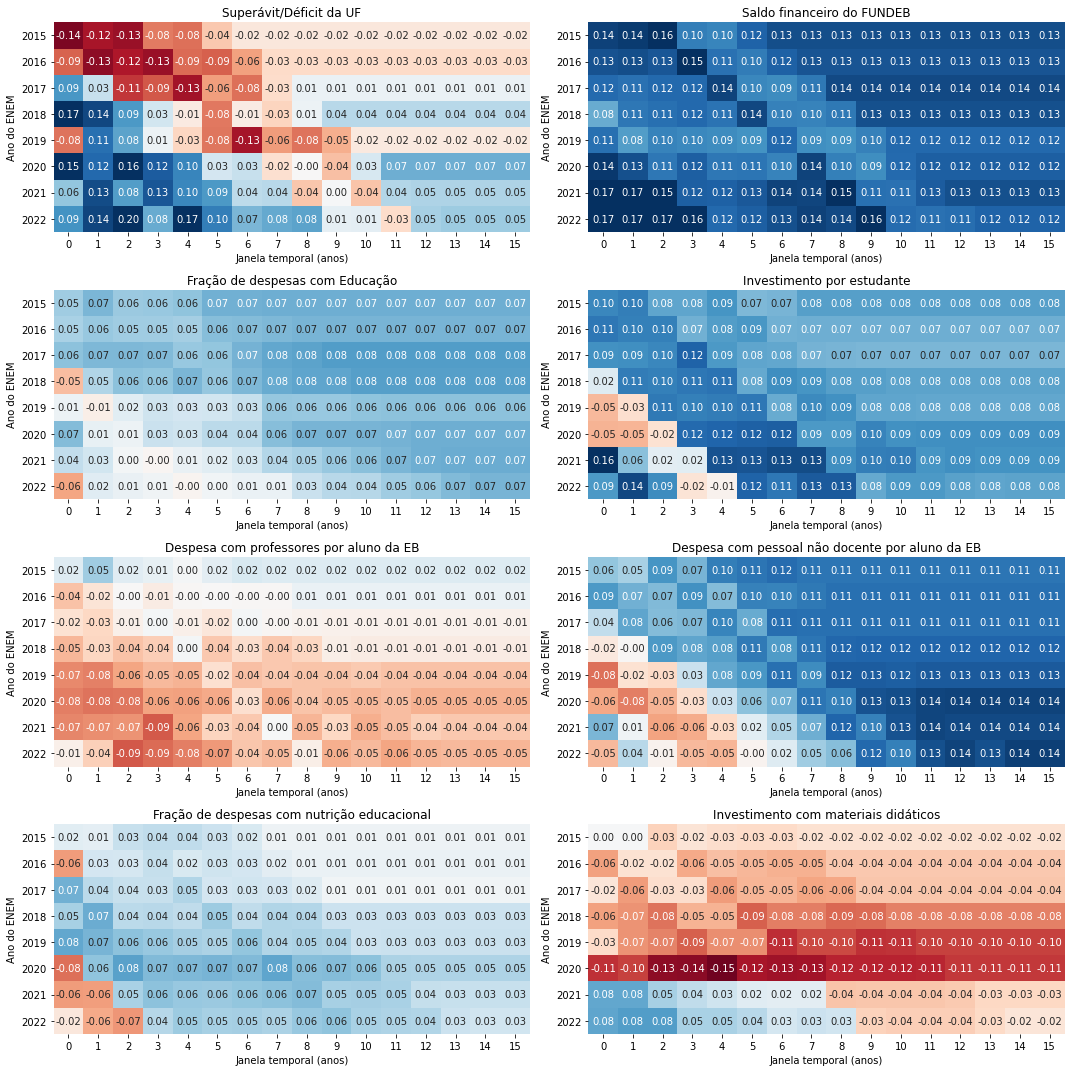

In [229]:
metrics_to_plot = ["superavit_or_deficit", "FUNDEB_balance", "education_to_overall_expanses",
                   "investment_per_student", "EB_expanses_teacher_per_student","EB_non_teaching_staff_per_student_expanses",
                   "scholar_nutrition_to_total_education_expanses", "courseware_investment"]
fig, ax = plt.subplots(4,2, figsize = (15,15))
ax = np.reshape(ax, (1,8))

#plt.suptitle("Correlações entre indicadores orçamentários educacionais e desempenho médio no ENEM")

i = 0
for metric in metrics_to_plot:
    df = siope_corr_df[siope_corr_df["metric"] == metric]
    # try:
    sns.heatmap(df.pivot(columns = "window", index = "year", values = "Average score"),
                    annot = True,
                    cmap = 'RdBu',
                    ax = ax[0,i],
                    cbar = False,
                    fmt = '.2f',
                    vmin = -0.15,
                    vmax = 0.15
                    )
    ax[0,i].set_xlabel("Janela temporal (anos)")
    ax[0,i].set_ylabel("Ano do ENEM")
    ax[0,i].set_title(f"{siope_dict_pt[metric]}")
    # except:
    #     print(f"Couldn't plot for {metric}")
    i += 1

plt.tight_layout()

In [40]:
siope_df["Region"] = siope_df["UF"].apply(lambda x:
                                    'Norte' if x in ["AC", "AM", "AP", "RO", "RR", "PA", "TO"]
                                    else 'Nordeste' if x in["MA", "PI", "BA", "CE", "PB", "RN", "PE", "AL", "SE"]
                                    else "Centro-Oeste" if x in ["MT", "GO", "DF", "MS"]
                                    else "Sudeste" if x in ["SP", "RJ", "MG", "ES"]
                                    else "Sul" if x in ["PR", "SC", "RS"]
                                    else "Nada")

In [214]:
siope_df[siope_df["metric_description"] == metric].groupby(["year","Region"])["metric_value"].mean().unstack()

Region  Centro-Oeste   Nordeste      Norte    Sudeste        Sul
year                                                            
2008       20.027500  14.746667  18.295714  14.017500  20.953333
2009       20.122500  14.914444  16.734286  13.355000  21.883333
2010       20.170000  15.214444  16.908000  13.950000  21.650000
2011       19.382500  16.923333  17.792857  14.005000  21.780000
2012       19.730000  16.172222  16.271429  14.165000  20.680000
2013       18.352500  14.852222  16.521429  14.142500  20.290000
2014       22.457500  15.443750  16.521429  13.836667  21.075000
2015       19.187500  14.642500  18.687143  13.950000  18.735000
2016       18.262500  14.853750  18.345714  14.360000  20.100000
2017       17.997500  14.550000  18.104286  13.946667  27.350000
2018       18.596667  15.016250  20.731429  13.100000  22.300000
2019       17.680000  16.626250  19.034286  14.373333  19.950000
2020       16.343333  14.758571  17.542857  13.980000  20.905000
2021       17.496667  17.515714  17.591429  13.880000  29.080000
2022       15.813333  17.130000  20.145714  14.155000  29.895000

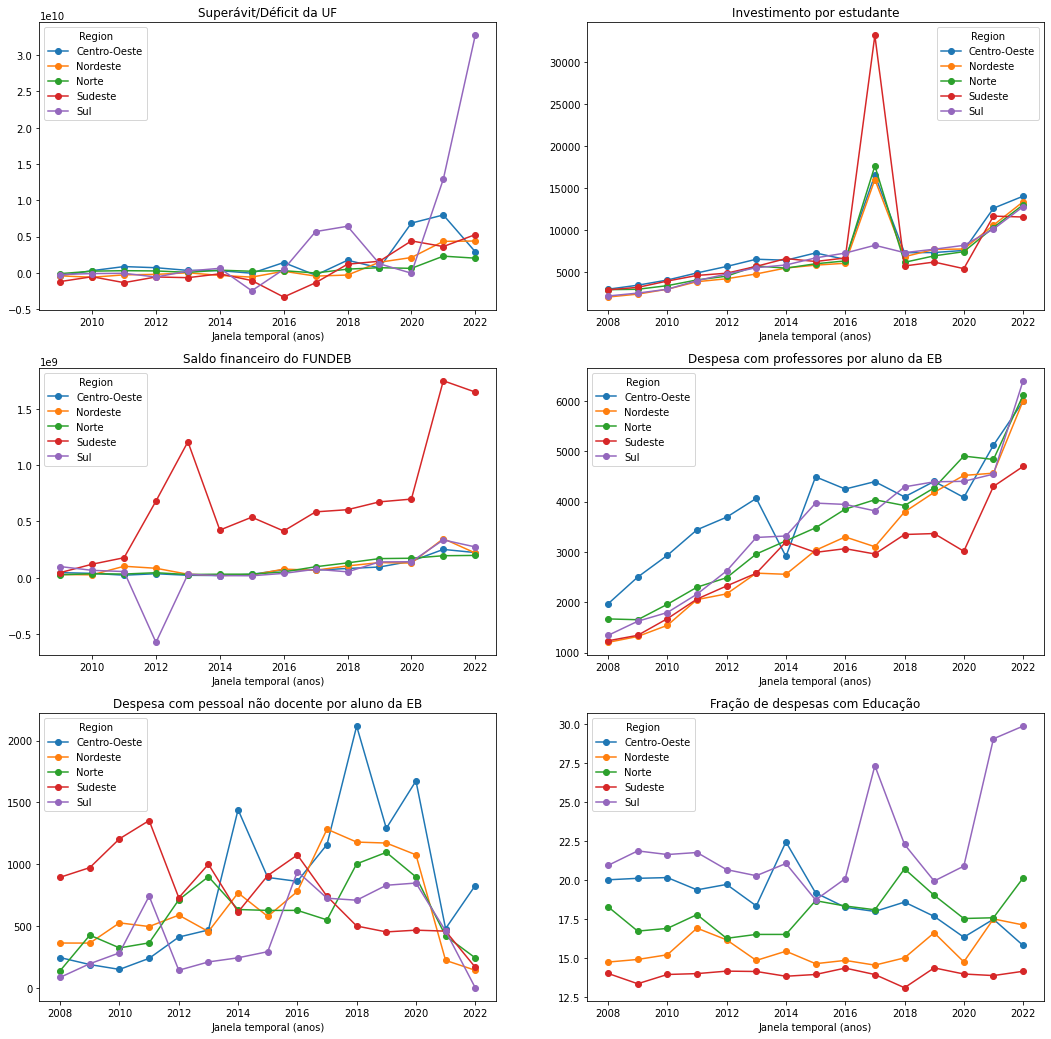

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

In [41]:
metrics_to_plot = ["superavit_or_deficit", "investment_per_student", "FUNDEB_balance", "EB_expanses_teacher_per_student", "EB_non_teaching_staff_per_student_expanses", "education_to_overall_expanses"]
fig, ax = plt.subplots(3,2, figsize = (18,18))
ax = np.reshape(ax, (1,6))

#plt.suptitle("Correlações entre indicadores orçamentários educacionais e desempenho médio no ENEM")

i = 0
for metric in metrics_to_plot:
    plt.figure(figsize = (12,9))

    siope_df[siope_df["metric_description"] == metric].groupby(["year","Region"])["metric_value"].mean().unstack().plot(marker = 'o',
                                                                                                                                    ax = ax[0,i])

    ax[0,i].set_xlabel("Janela temporal (anos)")
    ax[0,i].set_ylabel("")
    ax[0,i].set_title(f"{siope_dict_pt[metric]}")
    i += 1

plt.tight_layout()

## 3. PCA

### 3.1. Joining ENEM and SIOPE data.

We chose to join ENEM's data with SIOPE indicators from the last 8 years.

In [8]:
year = 2022
window = 8
grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()


In [91]:
siope_metrics_to_discard = (grouped_siope_df.isna().sum() > 0).where(lambda x: x == True).dropna().index

In [92]:
grouped_siope_df.drop(columns = siope_metrics_to_discard, inplace = True)

In [95]:
window = 8
for year in [2022]:
    R_external = pd.DataFrame()
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    enem_df.drop(columns = "UF", inplace = True)
    enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)

    # get metrics average values over last 'window' years
    print(f"Processing SIOPE data")
    grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()
    siope_metrics_to_discard = (grouped_siope_df.isna().sum() > 0).where(lambda x: x == True).dropna().index
    grouped_siope_df.drop(columns = siope_metrics_to_discard, inplace = True)

    print(f"Merging ENEM and SIOPE data")
    enem_with_siope_df = enem_df.merge(grouped_siope_df, on = "UF", how = "left")
    siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)
    
print("Done!")

Running analysis for ENEM 2022
Processing SIOPE data
Merging ENEM and SIOPE data


In [101]:
grouped_siope_df.shape

(24, 20)

In [102]:
enem_with_siope_df.dropna(inplace = True)

In [104]:
columns_to_scale = ["EB_expanses_teacher_per_student", "EB_investment_per_student", "EB_non_teaching_staff_per_student_expanses",
                    "EF_investment_per_student", "EI_investment_per_student", "EM_investment_per_student", "FUNDEB_balance",
                    "courseware_investment", "investment_per_student",
                    "superavit_or_deficit"]

df_to_scale = enem_with_siope_df[columns_to_scale]
enem_with_siope_df.drop(columns = columns_to_scale, inplace = True)

df_to_scale = (df_to_scale - df_to_scale.min())/(df_to_scale.max() - df_to_scale.min())
enem_with_siope_df = pd.concat([enem_with_siope_df, df_to_scale], axis = 1)

In [105]:
df = pd.get_dummies(enem_with_siope_df.drop(columns = ["TP_ESCOLA", "Natural Sciences score", "Humanities score", "Languages score",
                                                       "Average score", "ENEM_year", "UF", "Math score"]),
                    columns = ['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
                                   'Q001', 'Q002', 'Q003', 'Q004',
                                   'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
                                   'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
                                   'Q023', 'Q024', 'Q025', 'School type'])

In [106]:
pca = PCA(n_components = 2)
pca.fit(df.dropna())

PCA(n_components=2)

In [38]:
pca.components_.shape

(2, 210)

In [107]:
pca.explained_variance_ratio_

array([0.83540288, 0.06384893])

In [108]:
df_pca = pca.transform(df.dropna())

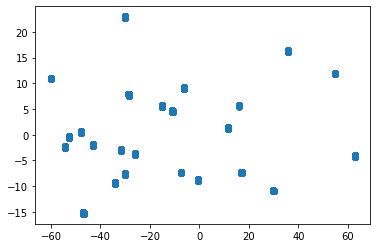

In [109]:
plt.scatter(x = df_pca[:,0], y = df_pca[:,1])

In [117]:
q1 = np.quantile(enem_with_siope_df["Average score"].dropna(),0.25)
q2 = np.quantile(enem_with_siope_df["Average score"].dropna(),0.50)
q3 = np.quantile(enem_with_siope_df["Average score"].dropna(),0.75)

In [120]:
enem_with_siope_df["Student_performance"] = enem_with_siope_df["Average score"].apply(lambda x: "Q3" if x > q3 
                                                                                      else "Q2" if x > q2
                                                                                      else "Q1")

In [121]:
enem_with_siope_df[["Average score", "Student_performance"]]

Average score Student_performance
0              507.800                  Q1
1              413.275                  Q1
2              407.625                  Q1
3              457.625                  Q1
4              485.875                  Q1
...                ...                 ...
2245643        503.775                  Q1
2245644        465.500                  Q1
2245645        587.400                  Q3
2245647        504.025                  Q1
2245648        593.825                  Q3

[1897637 rows x 2 columns]

In [123]:
enem_with_siope_df["Student_performance"].value_counts(normalize = True)

Q1    0.500081
Q3    0.249970
Q2    0.249949
Name: Student_performance, dtype: float64

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

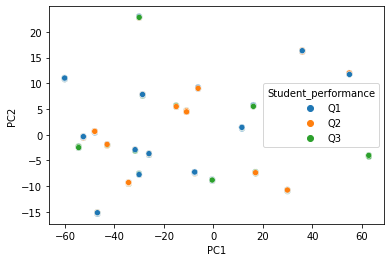

In [122]:
sns.scatterplot(data = pd.concat([pd.DataFrame(df_pca, columns = ["PC1", "PC2"]), enem_with_siope_df.dropna()["Student_performance"]],
                                 axis = 1),
                x = "PC1",
                y = "PC2",
                hue = "Student_performance")

In [77]:
grouped_siope_df.isna().sum()

metric_description
EB_expanses_teacher_per_student                   0
EB_investment_per_student                         0
EB_non_teaching_staff_per_student_expanses        0
EF_FUNDEB_ratio                                   0
EF_investment_per_student                         0
EF_to_total_education_expanses                    0
EI_FUNDEB_ratio                                   0
EI_investment_per_student                         0
EI_to_total_education_expanses                    0
EM_FUNDEB_ratio                                   0
EM_investment_per_student                         0
EM_to_total_education_expanses                    0
FUNDEB_balance                                    0
FUNDEB_not_used                                   3
FUNDEB_teacher_to_total_MDE                       0
average_teacher_expanses_EB                      16
courseware_investment                             0
education_to_overall_expanses                     0
education_to_total_MDE_investments           

In [75]:
enem_with_siope_df.head()

Age group Gender  Marital state  Ethinicity  Nacionality  \
0          5      F              1           2            1   
1          6      M              1           3            1   
2          6      F              1           2            1   
3          4      F              1           3            1   
4          2      F              1           1            1   

   High school conclusion year  TP_ESCOLA School type  UF  \
0                            2          1   No answer  BA   
1                            2          1   No answer  ES   
2                            0          1   No answer  RJ   
3                            1          1   No answer  PE   
4                            0          3     Private  SE   

   Natural Sciences score  ...  EB_non_teaching_staff_per_student_expanses  \
0                   421.1  ...                                    0.037556   
1                   490.7  ...                                    0.244621   
2                   398.1  ...                                    0.000000   
3                   467.5  ...                                    0.877172   
4                   458.7  ...                                    0.744752   

   EF_investment_per_student  EI_investment_per_student  \
0                   0.098694                   0.020477   
1                   0.194463                   0.000550   
2                   0.337511                   0.539259   
3                   0.306509                   0.029988   
4                   0.033576                   0.000740   

  EM_investment_per_student FUNDEB_balance FUNDEB_not_used  \
0                  0.225109       0.106679        0.630688   
1                  0.373627       0.035131        0.164852   
2                  0.288965       0.110213             NaN   
3                  0.290583       0.073300        1.000000   
4                  0.725414       0.000000        0.091473   

  average_teacher_expanses_EB  courseware_investment investment_per_student  \
0                         NaN               0.001130               0.343249   
1                    0.099757               0.000000               0.171743   
2                         NaN               0.000007               0.755430   
3                         NaN               0.043983               0.266016   
4                    0.048662               0.000000               0.247755   

  superavit_or_deficit  
0             0.356545  
1             0.307382  
2             0.000000  
3             0.190827  
4             0.226752  

[5 rows x 63 columns]

In [74]:
enem_with_siope_df.isna().sum().sort_values(ascending = False)[0:15]

average_teacher_expanses_EB                      1504381
FUNDEB_not_used                                   613654
investment_per_student_to_PIB_per_capita          391111
superavit_or_deficit                              348012
scholar_nutrition_to_total_education_expanses     348012
EF_FUNDEB_ratio                                   348012
EF_to_total_education_expanses                    348012
EI_FUNDEB_ratio                                   348012
EI_to_total_education_expanses                    348012
EM_FUNDEB_ratio                                   348012
EM_to_total_education_expanses                    348012
FUNDEB_teacher_to_total_MDE                       348012
education_to_overall_expanses                     348012
education_to_total_MDE_investments                348012
EB_expanses_teacher_per_student                   348012
dtype: int64

In [64]:
df.dropna().shape

(741268, 209)

In [124]:
dg = pd.DataFrame(pca.components_,columns=df.columns,index = ['PC-1','PC-2'])

In [65]:
dg.shape

(2, 209)

In [126]:
abs(dg.loc["PC-1", :]).sort_values(ascending = False)[0:15]

EM_FUNDEB_ratio                                  0.572088
EF_FUNDEB_ratio                                  0.561408
EM_to_total_education_expanses                   0.427275
EF_to_total_education_expanses                   0.411607
education_to_overall_expanses                    0.068909
EI_to_total_education_expanses                   0.017223
education_to_total_MDE_investments               0.015995
EI_FUNDEB_ratio                                  0.007279
FUNDEB_teacher_to_total_MDE                      0.006001
scholar_nutrition_to_total_education_expanses    0.003893
Q014_A                                           0.003835
Q014_B                                           0.003640
Q010_A                                           0.002982
Q016_A                                           0.002858
Q016_B                                           0.002763
Name: PC-1, dtype: float64

In [127]:
abs(dg.loc["PC-2", :]).sort_values(ascending = False)[0:15]

EM_to_total_education_expanses                0.774008
EF_to_total_education_expanses                0.408470
FUNDEB_teacher_to_total_MDE                   0.332835
EI_to_total_education_expanses                0.264869
EF_FUNDEB_ratio                               0.171515
EM_FUNDEB_ratio                               0.116762
education_to_total_MDE_investments            0.076968
EI_FUNDEB_ratio                               0.032875
investment_per_student                        0.023377
EB_investment_per_student                     0.022819
EB_non_teaching_staff_per_student_expanses    0.022429
FUNDEB_balance                                0.021094
EM_investment_per_student                     0.017075
High school conclusion year                   0.014154
education_to_overall_expanses                 0.013969
Name: PC-2, dtype: float64

In [63]:
pca.explained_variance_ratio_

array([0.64069824, 0.20520245])

## 4. Regressores

In [134]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS

c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [417]:
siope_data_with_scores_df.columns

Index(['UF', 'Average score', 'EI_FUNDEB_ratio', 'EF_FUNDEB_ratio',
       'EM_FUNDEB_ratio', 'EF_to_total_education_expanses',
       'EI_to_total_education_expanses', 'EM_to_total_education_expanses',
       'education_to_overall_expanses',
       'scholar_nutrition_to_total_education_expanses',
       'courseware_investment', 'education_to_total_MDE_investments',
       'average_teacher_expanses_EB', 'FUNDEB_teacher_to_total_MDE',
       'EI_investment_per_student', 'EF_investment_per_student',
       'EM_investment_per_student', 'EB_investment_per_student',
       'investment_per_student', 'EB_expanses_teacher_per_student',
       'EB_non_teaching_staff_per_student_expanses',
       'investment_per_student_to_PIB_per_capita', 'superavit_or_deficit',
       'FUNDEB_balance', 'FUNDEB_not_used'],
      dtype='object')

In [131]:
df_pca = pd.DataFrame(df_pca, columns = ["PC1", "PC2"])
df_pca.head()

PC1        PC2
0  29.905795 -10.752747
1 -10.888800   4.649784
2  17.009898  -7.265422
3 -15.049383   5.625712
4  16.133246   5.739628

In [133]:
df_pca["Average score"] = enem_with_siope_df.dropna()["Average score"]

In [141]:
groups = enem_with_siope_df.dropna()["UF"]
groups.shape

(1897637,)

In [143]:
data = df_pca.rename(columns = {'Average score': 'y'})
data.shape

(1897637, 3)

In [155]:
data["y"] = (data["y"] - data["y"].min())/(data["y"].max() - data["y"].min())

In [156]:
data.head()

PC1        PC2         y
0  29.905795 -10.752747  0.604668
1 -10.888800   4.649784  0.492111
2  17.009898  -7.265422  0.485383
3 -15.049383   5.625712  0.544921
4  16.133246   5.739628  0.578560

In [164]:
features_to_use = abs(dg.loc["PC-1", :]).sort_values(ascending = False)[0:15].index

In [166]:
data = df[features_to_use]

In [170]:
data["y"] = enem_with_siope_df.dropna()["Average score"]

<ipython-input-170-243a6f191069>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["y"] = enem_with_siope_df.dropna()["Average score"]


In [171]:
model = sm.MixedLM(endog = data["y"],
                   exog = data[features_to_use],
                   groups = groups).fit()

c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2189: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [172]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
==============================================================================================
Model:                        MixedLM            Dependent Variable:            y             
No. Observations:             1897637            Method:                        REML          
No. Groups:                   24                 Scale:                         4403.0472     
Min. group size:              4582               Log-Likelihood:                -10653372.8790
Max. group size:              363746             Converged:                     Yes           
Mean group size:              79068.2                                                         
----------------------------------------------------------------------------------------------
                                               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------------------------------------
EM_FUNDEB_ratio                                  6.188    2.087    2.965 0.003   2.098  10.278
EF_FUNDEB_ratio                                  5.565    3.336    1.668 0.095  -0.974  12.103
EM_to_total_education_expanses                  -0.358    2.080   -0.172 0.863  -4.434   3.718
EF_to_total_education_expanses                   0.197    3.739    0.053 0.958  -7.132   7.525
education_to_overall_expanses                   -0.172    4.892   -0.035 0.972  -9.760   9.416
EI_to_total_education_expanses                  -0.394    5.691   -0.069 0.945 -11.547  10.759
education_to_total_MDE_investments              -0.426   11.313   -0.038 0.970 -22.600  21.747
EI_FUNDEB_ratio                                 14.013   15.352    0.913 0.361 -16.076  44.102
FUNDEB_teacher_to_total_MDE                     -0.547    2.406   -0.227 0.820  -5.262   4.168
scholar_nutrition_to_total_education_expanses   -5.653   39.391   -0.144 0.886 -82.857  71.551
Q014_A                                         -14.521    0.446  -32.540 0.000 -15.396 -13.647
Q014_B                                           2.275    0.431    5.282 0.000   1.431   3.119
Q010_A                                         -26.979    0.115 -235.336 0.000 -27.204 -26.755
Q016_A                                         -23.480    0.548  -42.870 0.000 -24.553 -22.406
Q016_B                                          -6.063    0.540  -11.228 0.000  -7.121  -5.004
Group Var                                     4403.047                                        
==============================================================================================

"""

In [173]:
y_pred = model.predict(data[features_to_use])

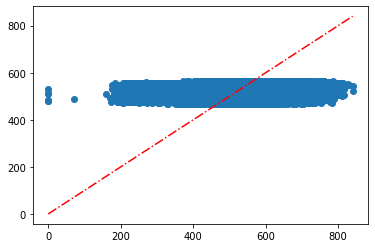

In [175]:
plt.scatter(data["y"], y_pred)

xx = np.linspace(data["y"].min(), data["y"].max())
yy = xx
plt.plot(xx, yy, 'r-.')

In [176]:
model.cov_re

Group Var
Group Var  4403.047226

In [183]:
print(model.__doc__)


    Class to contain results of fitting a linear mixed effects model.

    MixedLMResults inherits from statsmodels.LikelihoodModelResults

    Parameters
    ----------
    See statsmodels.LikelihoodModelResults

    Attributes
    ----------
    model : class instance
        Pointer to MixedLM model instance that called fit.
    normalized_cov_params : ndarray
        The sampling covariance matrix of the estimates
    params : ndarray
        A packed parameter vector for the profile parameterization.
        The first `k_fe` elements are the estimated fixed effects
        coefficients.  The remaining elements are the estimated
        variance parameters.  The variance parameters are all divided
        by `scale` and are not the variance parameters shown
        in the summary.
    fe_params : ndarray
        The fitted fixed-effects coefficients
    cov_re : ndarray
        The fitted random-effects covariance matrix
    bse_fe : ndarray
        The standard errors of the fitt

In [187]:
model.fittedvalues

0          485.961866
1          529.572857
2          543.283695
3          492.749030
4          488.678959
              ...    
2245643    515.683875
2245644    538.145068
2245645    497.188598
2245647    513.831678
2245648    550.800572
Length: 1897637, dtype: float64

In [200]:
model.fittedvalues.var()

751.9123910954969

In [191]:
np.diag(model.cov_params()).sum()

2012.01884168907

In [189]:
model.cov_params()

EM_FUNDEB_ratio  \
EM_FUNDEB_ratio                                       4.354626   
EF_FUNDEB_ratio                                      -1.749795   
EM_to_total_education_expanses                       -3.551413   
EF_to_total_education_expanses                        3.780209   
education_to_overall_expanses                        -0.472034   
EI_to_total_education_expanses                       -2.321372   
education_to_total_MDE_investments                    3.708536   
EI_FUNDEB_ratio                                       6.057841   
FUNDEB_teacher_to_total_MDE                          -2.884722   
scholar_nutrition_to_total_education_expanses       -21.862041   
Q014_A                                               -0.001453   
Q014_B                                               -0.001475   
Q010_A                                               -0.000014   
Q016_A                                               -0.002424   
Q016_B                                               -0.002485   
Group Var                                            -0.000002   

                                               EF_FUNDEB_ratio  \
EM_FUNDEB_ratio                                      -1.749795   
EF_FUNDEB_ratio                                      11.129673   
EM_to_total_education_expanses                        1.847939   
EF_to_total_education_expanses                      -10.921653   
education_to_overall_expanses                        -9.474085   
EI_to_total_education_expanses                       13.440502   
education_to_total_MDE_investments                  -24.360686   
EI_FUNDEB_ratio                                      -7.578714   
FUNDEB_teacher_to_total_MDE                           2.124606   
scholar_nutrition_to_total_education_expanses        55.002068   
Q014_A                                               -0.001288   
Q014_B                                               -0.001402   
Q010_A                                                0.000013   
Q016_A                                               -0.002314   
Q016_B                                               -0.002458   
Group Var                                             0.000003   

                                               EM_to_total_education_expanses  \
EM_FUNDEB_ratio                                                     -3.551413   
EF_FUNDEB_ratio                                                      1.847939   
EM_to_total_education_expanses                                       4.324885   
EF_to_total_education_expanses                                      -2.149423   
education_to_overall_expanses                                       -1.391911   
EI_to_total_education_expanses                                      -0.572094   
education_to_total_MDE_investments                                  -7.050182   
EI_FUNDEB_ratio                                                      4.578954   
FUNDEB_teacher_to_total_MDE                                          0.653688   
scholar_nutrition_to_total_education_expanses                       15.452790   
Q014_A                                                              -0.000076   
Q014_B                                                              -0.000014   
Q010_A                                                               0.000005   
Q016_A                                                              -0.000114   
Q016_B                                                              -0.000062   
Group Var                                                            0.000001   

                                               EF_to_total_education_expanses  \
EM_FUNDEB_ratio                                                      3.780209   
EF_FUNDEB_ratio                                                    -10.921653   
EM_to_total_education_expanses                                      -2.149423   
EF_to_total_education_expanses                                      13.980944   
education_to_overa

In [197]:
model.cov_re

Group Var
Group Var  4403.047226

In [148]:
model = smf.mixedlm(formula = "y ~ PC1 + PC2 + 1", 
    data = data,
    groups = groups,
    re_formula = "1").fit()

IndexError: index 1612678 is out of bounds for axis 0 with size 1612024

In [412]:
model.cov_re

Group
Group  313.514258

In [428]:
OLS_null = smf.ols(formula = "y ~ 1", data = siope_data_with_scores_df.rename(columns = {'Average score': 'y'})).fit()

In [431]:
OLS_null.llf

-3752392.8866953664

In [432]:
model.llf

-3729573.1750320885

In [433]:
(model.llf - OLS_null.llf)/model.llf

-0.006118585315887114

In [434]:
model.cov_re

Group
Group  331.925595

In [436]:
(model.cov_re + model.scale)/model.cov_re

Group
Group  15.461455

In [438]:
y_pred = model.predict(siope_data_with_scores_df[['EF_FUNDEB_ratio', 'EM_FUNDEB_ratio', 'EF_to_total_education_expanses', 'investment_per_student']])

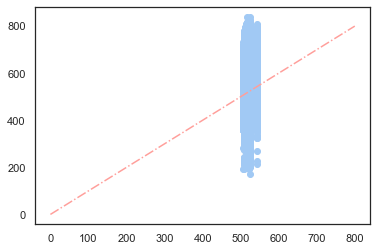

In [444]:
plt.scatter(y_pred, siope_data_with_scores_df["Average score"])
xx = np.linspace(0, 800)
yy = xx
plt.plot(xx,yy, '-.r')

In [451]:
from sklearn.metrics import r2_score
r2_score(siope_data_with_scores_df["Average score"], y_pred, force_finite = True)

-0.013944631678285191

In [437]:
model.normalized_cov_params

Intercept  EF_FUNDEB_ratio  \
Intercept                       6.419099e+00    -6.791473e-02   
EF_FUNDEB_ratio                -6.791473e-02     7.488751e-04   
EM_FUNDEB_ratio                -6.212126e-02     6.573440e-04   
EF_to_total_education_expanses  4.710293e-03    -8.156931e-05   
investment_per_student         -1.761614e-05     1.667240e-07   
Group Var                       2.140058e-07    -1.506948e-09   

                                EM_FUNDEB_ratio  \
Intercept                         -6.212126e-02   
EF_FUNDEB_ratio                    6.573440e-04   
EM_FUNDEB_ratio                    6.089317e-04   
EF_to_total_education_expanses    -4.320224e-05   
investment_per_student             1.147930e-07   
Group Var                         -1.447569e-09   

                                EF_to_total_education_expanses  \
Intercept                                         4.710293e-03   
EF_FUNDEB_ratio                                  -8.156931e-05   
EM_FUNDEB_ratio                                  -4.320224e-05   
EF_to_total_education_expanses                    4.237769e-05   
investment_per_student                           -3.686221e-08   
Group Var                                        -9.415777e-10   

                                investment_per_student     Group Var  
Intercept                                -1.761614e-05  2.140058e-07  
EF_FUNDEB_ratio                           1.667240e-07 -1.506948e-09  
EM_FUNDEB_ratio                           1.147930e-07 -1.447569e-09  
EF_to_total_education_expanses           -3.686221e-08 -9.415777e-10  
investment_per_student                    6.434971e-10 -4.850830e-12  
Group Var                                -4.850830e-12  1.067017e-07

In [425]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                  MixedLM       Dependent Variable:       y            
No. Observations:       659252        Method:                   REML         
No. Groups:             27            Scale:                    4800.1269    
Min. group size:        1293          Log-Likelihood:           -3729573.1750
Max. group size:        133816        Converged:                Yes          
Mean group size:        24416.7                                              
-----------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------------------------
Intercept                      702.755  175.535  4.004 0.000 358.713 1046.798
EF_FUNDEB_ratio                 -1.339    1.896 -0.706 0.480  -5.055    2.377
EM_FUNDEB_ratio                 -1.797    1.710 -1.051 0.293  -5.148    1.554
EF_to_total_education_expanses  -0.438    0.451 -0.971 0.331  -1.322    0.446
investment_per_student          -0.001    0.002 -0.673 0.501  -0.005    0.002
Group Var                      331.926    1.568                              
=============================================================================

"""

In [408]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: y            
No. Observations: 659252  Method:             REML         
No. Groups:       27      Scale:              4800.1408    
Min. group size:  1293    Log-Likelihood:     -3729570.4134
Max. group size:  133816  Converged:          Yes          
Mean group size:  24416.7                                  
-----------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    519.222    3.368 154.162 0.000 512.621 525.824
Group Var    305.731    1.214                              
===========================================================

"""

In [ ]:
def run_longitudinal_correlation_analysis(years_to_analyze, time_window):
    R_external_all_years = {}
    for year in years_to_analyze:
        R_external = pd.DataFrame()
        print(f"Running analysis for ENEM {year}")
        for window in n:
            print(f"Running for the last {window} year(s)")
            # get metrics average values over last 'window' years
            grouped_siope_df = siope_df[(siope_df['year'] >= year - window)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

            siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)
            r = siope_data_with_scores_df.corr(method = 'spearman', numeric_only = True)
            r["window"] = window
            R_external = pd.concat([R_external, r[["Average score", "window"]]], axis = 0)

            del siope_data_with_scores_df
        joblib.dump(R_external, f"siope_correlations_ENEM_{year}.pkl")

        R_external_all_years[year] = R_external
        del R_external
    
    return R_external_all_years 
    